In [1]:
import ollama

import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from sklearn.feature_extraction.text import TfidfVectorizer
from reco_systems.filter import filter_df
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *

from surprise import NMF
from surprise import Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances

from IPython.core.display import display_html

import textwrap # to avoid scrolling on long strings in jupyter
#%load_ext autoreload
#%autoreload 2
%matplotlib inline


In [59]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 
rev_filter = filter_df(avis_clean, min_reviews)
games_means = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().reset_index()

rev_filter = rev_filter.assign(index=rev_filter.index)
rev_filter["Length"] = rev_filter["Comment body"].str.split().apply(len)

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [4]:
lemmas = pd.read_csv("../generated_data/Lemmas_VER_cleaned.csv", index_col=0)
lemmas = lemmas[~lemmas["Lemma"].isna()]
comment_lemmatized = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index().dropna(subset=["Lemma"])
comment_lemmatized = comment_lemmatized.merge(rev_filter[["Game id", "User id", "index"]], left_on="Comment line", right_on="index").rename(columns={"Lemma":"Comment body"})

In [ ]:
# Embeddings on all games descriptions
# games_filter = jeux_clean[jeux_clean["Game id"].isin(rev_filter["Game id"])].sort_values("Game id")[["Game id", "Description"]]

# from FlagEmbedding import BGEM3FlagModel

# model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation

# descriptions = games_filter["Description"].tolist()

# # Batch encode
# encoded = model.encode(
#     descriptions,
#     batch_size=12,         # now this matters
#     max_length=6144,       # truncate long ones
#     return_dense=True,     # default is True, but explicit is good
# )

,Game id,Description
6,6,Chaque joueur essaie de se débarrasser le plus...
15,15,"""Dans quelle galère je me suis encore fourrée ..."
25,25,Aucune description
28,28,Incarnez les deux surpuissances de la Guerre F...
34,34,Nous sommes en 1775. Outragées par les nouvell...
...,...,...
10507,10507,But du jeu Être le premier joueur à effrayer l...
10508,10508,Ce jeu est la réactualisation (2009) de la pre...
10514,10514,«À la Gloire d’Odin» raconte une saga épique à...
10531,10531,"Mettez en échec le roi de votre adversaire, mi..."


### Summarizing game/user comments 

In [90]:
def assign_batch_number(df, max_length):
    batch_number = 0
    current_length = 0
    batch_numbers = []

    for length in df['Length']:
        if current_length + length > max_length:
            batch_number += 1
            current_length = 0  # Reset the current length
        batch_numbers.append(batch_number)
        current_length += length

    return batch_numbers

def call_model_by_batch(comments_batched:pd.DataFrame, prompt_type:str) -> str:
    # prompt_type = "user", "game"
    prompt_types = {
        "user" : f"""You will receive multiple comments from a single user about different board games.
        These comments are in French and are separated by newlines.
        Your goal is to summarize the user’s overall preferences by identifying what they liked and disliked across all the games.""",

        "game" : f"""You will receive multiple comments from different users about a single board game.
        These comments are in French and are separated by newlines.
        Your goal is to summarize the game's overall strengths and weaknesses based on these comments
        """,

        "generate_comment" : """You are an expert in analyzing user reviews and generating realistic
        comments based on similar opinions. I will give you comments from different users about the board game (comments by different usersare separated by newlines)
        Based on these comments, generate a new user comment that: feels natural and realistic, reflects the general sentiment and themes from the given comments and
        introduces slight variations in style and phrasing to sound unique. Here are users comments : """,

        """descriptions""" : """You will receive multiple board game descriptions in French. Each description is separated by a newline.
        Your task is to summarize these descriptions and to identify key mechanics, target audience, qualit, complexity etc.
        The goal is to find what is in common for all these games. Here are the descriptions:""", 

        "desc_summary" : """You will receive descriptions in Frenchon 10 board games. Each description is separated by a newline.
        Your task is to summarize all these descriptions one by one. Here are the descriptions:"""
    }
    prompt = prompt_types[prompt_type]
    messages = [{"role": "user", "content": prompt + comments_batched[0]}]
    messages += [{"role":"user", "content":comments_batched[i]} for i in range(1, len(comments_batched))]
    print(len(messages))
    response = ollama.chat(model='llama3.2', messages=messages)
    print("Nb tokens:", response["prompt_eval_count"])
    return response

def calc_nb_words(comments:pd.DataFrame) -> int:
    return comments.str.split().explode().size

#### Number of reviews per user

In [5]:
users_count = rev_filter.groupby("User id").agg(count=('Game id', 'count'), mean=('Rating', 'mean')).reset_index().sort_values(by="mean").head(30)
games_count = rev_filter.groupby("Game id").agg(count=('User id', 'count'), mean=('Rating', 'mean')).reset_index().sort_values(by="mean").head(30)

users_styler = users_count.style.set_table_attributes("style='display:inline'").set_caption('Users count reviews, mean rating')
games_styler = games_count.style.set_table_attributes("style='display:inline'").set_caption('Users count reviews, mean rating')
    
display_html(users_styler._repr_html_()+games_styler._repr_html_(), raw=True)

,User id,count,mean
491,1474,13,3.500000
1281,3683,43,4.139535
432,1207,41,4.141463
1714,5625,10,4.160000
1827,6888,12,4.500000
1664,5196,12,4.500000
66,111,119,4.554622
1735,6078,10,4.600000
1569,4730,11,4.727273
274,614,39,4.782051


### Game's comments

**Game with 147 reviews and mean rating : 8.15**

In [305]:
game = 4982
game_comments = rev_filter[rev_filter["Game id"] == game]
game_comments = game_comments.assign(Batch=assign_batch_number(game_comments, 2300))
game_comments_batched = game_comments.groupby("Batch")["Comment body"].apply("\n".join).tolist()
print("Nb words:", calc_nb_words(game_comments["Comment body"]))
response = call_model_by_batch(game_comments_batched, "game")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Nb words: 15826
8


KeyboardInterrupt: 

**Game with 140 reviews and mean rating : 6.74**

In [ ]:
game = 4342
game_comments = rev_filter[rev_filter["Game id"] == game]
game_comments = game_comments.assign(Batch=assign_batch_number(game_comments, 2300))
game_comments_batched = game_comments.groupby("Batch")["Comment body"].apply("\n".join).tolist()
print("Nb words:", calc_nb_words(game_comments["Comment body"]))
response = call_model_by_batch(game_comments_batched, "game")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Nb words: 9350
5
Il semble que vous avez lu une série d'avis et de critiques sur le jeu de cochon, mais sans fournir
un texte cohérent. Cependant, je vais essayer de résumer les points clés des avis :

* Le jeu est facile à transporter et peut être joué partout.
* Il est simple et amusant, même pour les enfants.
* Les deux cochons en plastique sont charmants et fonctionnent comme des dés.
* Le jeu est rapide et parfait pour les moments où on a peu de temps.
* Il est convivial et peut être joué avec des amis ou des enfants.
* Les cochons ont des postures différentes, ce qui ajoute à la surprise et l'aléatoire du jeu.
* Le jeu tient dans une pochette de rangement petite.
* Il est facile à comprendre et à jouer.

Cependant, il y a également quelques critiques mentionnées :

* Le jeu peut être considéré comme stupide au premier abord.
* Les cochons peuvent être un peu mal faits.
* Le jeu n'a pas une grande pertinence ou intérêt.
* Il est préférable à un jeu de dés traditionnel.

En résumé,

**Game with 93 reviews and mean ratings : 3.27**

In [ ]:
game = 4360
game_comments = rev_filter[rev_filter["Game id"] == game]
game_comments = game_comments.assign(Batch=assign_batch_number(game_comments, 2300))
game_comments_batched = game_comments.groupby("Batch")["Comment body"].apply("\n".join).tolist()
print("Nb words:", calc_nb_words(game_comments["Comment body"]))
response = call_model_by_batch(game_comments_batched, "game")
print("\n".join(textwrap.fill(word, width=100) for word in response['message']['content'].split('\n')))

Nb words: 5086
3
Il semble que le texte que vous avez fourni est une critique humoristique de l'intégralité du jeu
Monopoly, plutôt qu'une véritable analyse. L'auteur y déclare son mépris pour le jeu, en le
comparant à un "plat" et en se moquant de son manque d'intérêt.

Cependant, si vous souhaitez en savoir plus sur les différentes variantes ou modifications du jeu
Monopoly qui pourraient rendre ce jeu plus intéressant, voici quelques suggestions :

1. Ajouter des objectifs supplémentaires : au lieu de simplement parcourir le tablier et de faire
face à l'embuches, vous pourriez ajouter des objectifs supplémentaires, tels que la collecte de
certaines pièces ou la réalisation d'équations mathématiques. Cela pourrait rendre le jeu plus
complexe et intéressant.
2. Introduire une éléments aléatoires : vous pourriez ajouter des éléments aléatoires au jeu, tels
que des cartes qui s'ajoutent au jeu ou des défis mathématiques à résoudre. Cela pourrait rendre le
jeu plus dynamique et excitant.

### Comments embeddings per cluster

In [72]:
model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)

games_ids = np.array([trainset.to_raw_iid(i) for i in range(len(G))])
users_ids = np.array([trainset.to_raw_uid(u) for u in range(len(U))])
G = G[np.argsort(games_ids), :]

NB_CLUSTERS = 30
kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=42) 
kmeans.fit(G) 

games_clusters = pd.DataFrame(data={"Game id":np.sort(games_ids), "Cluster":kmeans.labels_})

Python(2187) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Embeddings on comments per clusters
Only comments that have $10$ to $300$ words are selected

In [73]:
comment_real = rev_filter[(rev_filter["Length"] >= 10) & (rev_filter["Length"] <= 300)][["User id", "Game id", "index", "Comment body"]]

# comment_lemmatized = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index().dropna(subset=["Lemma"])
# comment_lemmatized = comment_lemmatized.merge(rev_filter[["Game id", "User id"]], left_on="Comment line", right_index=True)

comment_lemmatized = comment_lemmatized.merge(comment_real[["index"]], left_on="Comment line", right_on="index").sort_values("Comment line")
comment_real = comment_real.merge(comment_lemmatized[["Comment line"]], right_on="Comment line", left_on="index").sort_values("index")

comment_lemmatized.shape, comment_real.shape

((89508, 6), (89508, 5))

#### TF-IDF on bigrams

In [70]:
desc_lemmas = pd.read_csv("../generated_data/desc_lemmas.csv", index_col=0)

# Errors in lemmatization
desc_lemmas.loc[(desc_lemmas["Lemma"] == "poindre") & (desc_lemmas["Tokens"] == "points"), ["Lemma", "POS"]] = ["point", "NOM"] 
desc_lemmas.loc[(desc_lemmas["Lemma"] == "poindre") & (desc_lemmas["Tokens"] == "poins"), ["Lemma", "POS"]] = ["poin", "NOM"] 
desc_lemmas.loc[(desc_lemmas["Lemma"] == "poindre") & (desc_lemmas["Tokens"] == "pointes"), ["Lemma", "POS"]] = ["pointes", "NOM"] 

desc_lemmatized = desc_lemmas.groupby("Game id")["Lemma"].apply(" ".join).reset_index().rename(columns={"Lemma":"Description"})

desc_embeddings = pd.read_parquet("../generated_data/descriptions_embeddings.parquet")

# Delete games that have no description
desc_embeddings = desc_embeddings[~desc_embeddings["Description"].str.contains("Aucune description")]
desc_embeddings["Length"] = desc_embeddings["Description"].str.split().apply(len)

# Find intersection
desc_lemmatized = desc_lemmatized[desc_lemmatized["Game id"].isin(desc_embeddings["Game id"])]
desc_lemmatized.shape, desc_embeddings.shape

((2529, 2), (2529, 4))

In [11]:
# bigrams = BigramCollocationFinder.from_documents(desc_lemmatized["Description"].str.split().tolist())
# bigrams_freq = bigrams.score_ngrams(BigramAssocMeasures.raw_freq)

# bigrams_df = pd.DataFrame(data=[list(info) for info in bigrams_freq])

# bigrams_df[0] = bigrams_df[0].apply(list).apply(" ".join)
# bigrams_df = bigrams_df.rename(columns={0:"Lemma", 1:"Freq"})

# bigrams_df = bigrams_df[~bigrams_df["Lemma"].str.contains("joueur")]

# sns.set_theme(rc={"figure.figsize":(7, 15)})
# sns.barplot(data=bigrams_df.sort_values("Freq").tail(80), x="Freq", y="Lemma")

In [ ]:
# count = desc_lemmas["Lemma"].value_counts().reset_index().sort_values(by="count", ascending=False)
# corpus = count[count["count"] >= 3]["Lemma"].values
# desc_lemmas = desc_lemmas[desc_lemmas["Lemma"].isin(corpus)]

# # desc_lemmas = desc_lemmas[desc_lemmas["Game id"].isin(count.loc[count["Lemma"] >= 10, "Game id"])]

# desc_lemmatized = desc_lemmas.groupby("Game id")["Lemma"].apply(" ".join).reset_index().rename(columns={"Lemma":"Description"})
# desc_lemmatized.shape

(2614, 2)

In [ ]:
# vectorizer = TfidfVectorizer(ngram_range=(2, 2)) # tfidf on bigrams
# desc_tfidf = vectorizer.fit_transform(desc_lemmatized["Description"])

# # Convert back to description
# games, bigrams = desc_tfidf.nonzero()
# tfidf = desc_tfidf.data
# ptr = desc_tfidf.indptr
# corpus = vectorizer.get_feature_names_out()

# threshold = 0.1

# bigrams_df = pd.DataFrame(data={"index":games, 
#                                 "Bigrams":[corpus[b] for b in bigrams], 
#                                 "tdidf":tfidf})

# games_map = pd.DataFrame(data={"index": np.arange(0, desc_lemmatized.shape[0]), 
#                                "Game id" : desc_lemmatized["Game id"]})

# bigrams_df = bigrams_df[bigrams_df["tdidf"] > threshold]
# games_bigrams = bigrams_df.merge(games_map, on="index")
# games_filter = games_bigrams.groupby("Game id")["Bigrams"].apply(" ".join).reset_index().rename(columns={"Bigrams":"Description"})
# games_filter
# games_filter_real = jeux_clean[jeux_clean["Game id"].isin(games_filter["Game id"])][["Game id", "Description"]]

In [68]:
def find_represent_comment(cluster:int, games_clusters:pd.DataFrame, text_lemmatized:pd.DataFrame, 
                           text_real_embeddings:pd.DataFrame, column_name:str):
    # all comments per cluster
    games_in_cluster = games_clusters[games_clusters["Cluster"] == cluster]
    text_real_embeddings = text_real_embeddings[text_real_embeddings["Game id"].isin(games_in_cluster["Game id"])].sort_values("Game id")
    text_lemmatized = text_lemmatized[text_lemmatized["Game id"].isin(games_in_cluster["Game id"])].sort_values("Game id")

    #print(real_text, text_lemmatized)
    print("Nb texts :", text_real_embeddings.shape[0], text_lemmatized.shape[0])

    # Extract embeddings
    embeddings = np.array(text_real_embeddings["Embedding"].tolist())
    
    # Find mean comment
    mean_text = embeddings.mean(axis=0) 

    # Find closest existing comment 
    dist = cosine_distances(mean_text.reshape(1, -1), embeddings)
    #print(dist.shape)
    return text_real_embeddings, text_lemmatized, embeddings, dist.flatten()

def plot_bigrams(text_selected, ax=None):
    bigrams = BigramCollocationFinder.from_documents(text_selected.str.split().tolist())
    bigrams_freq = bigrams.score_ngrams(BigramAssocMeasures.raw_freq)

    bigrams_df = pd.DataFrame(data=[list(info) for info in bigrams_freq])

    bigrams_df[0] = bigrams_df[0].apply(list).apply(" ".join)
    bigrams_df = bigrams_df.rename(columns={0:"Lemma", 1:"Freq"})

    if ax is not None:
        ax = sns.barplot(data=bigrams_df.sort_values(by="Freq", ascending=False).head(40), x="Freq", y="Lemma", ax=ax)
    else:
        sns.set_theme(rc={"figure.figsize":(15, 6)})
        ax = sns.barplot(data=bigrams_df.sort_values(by="Freq", ascending=False).head(90), y="Freq", x="Lemma")
        ax.set_xticks(ax.get_xticks())  # Explicitly set tick locations
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90); # ; to avoid printing return value
        ax.set_title(f"Nb texts selected : {text_selected.size}")
    

def plot_bigrams_both(comments_selected, desc_selected):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    plot_bigrams(comments_selected, ax1)
    ax1.set_title("Comments bigrams")

    plot_bigrams(desc_selected, ax2)
    ax2.set_title("Descriptions bigrams")

    plt.tight_layout()

def describe_cluster(cluster, perc_desc, perc_comments, llm_k, games_clusters, desc_lemmatized, desc_real,
                     comments_lemmatized, comments_real, comments=False):

    real_desc_cluster, lemmas_desc_cluster, embeddings, dist_desc = find_represent_comment(cluster, games_clusters,
                                                                                      desc_lemmatized, desc_real, "Description")
    print("Description embeddings completed")

    # Treat descriptions
    dist_min_desc = np.min(dist_desc)
    closest_desc = np.argwhere(dist_desc <= dist_min_desc * perc_desc).flatten()
    #closest_desc = np.argpartition(dist_desc.flatten(), 10)[:10]
    
    # Treat comments
    if comments:
        real_comments_cluster, lemmas_comments_cluster, embeddings, dist_comments = find_represent_comment(cluster, games_clusters,
                                                                             comments_lemmatized, comments_real, "Comment body")
        print("Comments embeddings completed")

        dist_min_comments = np.min(dist_comments)
        closest_comments = np.argwhere(dist_comments <= dist_min_comments * perc_comments).flatten()

        print('\033[1m' + "CENTER COMMENT :" + '\033[0m', textwrap.fill(real_comments_cluster.iloc[np.argmin(dist_comments)]["Comment body"], width=100))

        print(real_desc_cluster.shape, real_comments_cluster.shape, dist_desc.shape, dist_comments.shape)
    desc_for_llm = real_desc_cluster.iloc[np.argpartition(dist_desc.flatten(), llm_k)[:llm_k]]
    if comments:
        plot_bigrams_both(lemmas_comments_cluster.iloc[closest_comments]["Comment body"], lemmas_desc_cluster.iloc[closest_desc]["Description"])
    else:
        print("Distance descriptions : ", np.sort(dist_desc)[:llm_k])
        plot_bigrams(lemmas_desc_cluster.iloc[closest_desc]["Description"])

    print('\033[1m' + "CENTER DESC :" + '\033[0m', textwrap.fill(real_desc_cluster.iloc[np.argmin(dist_desc)]["Description"], width=100), "\n")

    return desc_for_llm

def plot_bigrams_tfidf(games_bigrams, games):
    games_bigrams = games_bigrams[games_bigrams["Game id"].isin(games)]

    bigrams_df = games_bigrams.groupby("Bigrams")["Game id"].nunique().reset_index(name="Freq")
    # bigrams_games_count = games_bigrams.groupby("Bigrams")["Game id"].nunique().reset_index(name="Games Appeared")

    # bigrams_df = pd.merge(bigrams_freq, bigrams_games_count, on="Bigrams")

    # bigrams_df["Freq"] = bigrams_df["Freq"]


    sns.set_theme(rc={"figure.figsize":(15, 6)})
    ax = sns.barplot(data=bigrams_df.sort_values(by="Freq", ascending=False).head(100), y="Freq", x="Bigrams")
    ax.set_xticks(ax.get_xticks())  # Explicitly set tick locations
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90); # ; to avoid printing return value

#### Cluster 5

**Thème commun : La conquête et le pouvoir**

Unigrams/Bigrams:
- acquerir suprémacie
- phase attaquer
- pétrole
- rail
- proteger monde
- bombe atomique
- six superpuissance

**Targeted public : adults**

Nb texts : 81 81
Description embeddings completed
Distance descriptions :  [0.1886893  0.21740057 0.22066629 0.22753858 0.23107607 0.23126043
 0.23182972 0.24027997 0.24933746 0.25028175]
CENTER DESC : Déroulement du jeu Chaque joueur possède son propre parcours, que sa figurine doit réaliser. Pour
pouvoir se frayer un chemin, les joueurs doivent au préalable rassembler les cartes appropriées. Ce
n’est pas vraiment si simple, car tous fouillent en même temps dans les cartes qui sont face
cachées. Ce qui peut être utilisé est conservé. Les autres cartes sont rejetées face visibles, et
les adversaires peuvent s’en emparer. Seul celui qui rassemble les cartes dans l’ordre correct,
progressera sur son parcours. Fin de partie Celui qui après plusieurs étapes atteint en premier son
objectif, gagne la course. Dans la version experte, celui qui, après plusieurs courses, obtient le
plus de points, est le gagnant. Matériel du jeu 28 cartes Parcours (sur chacune est représenté 18
types de terrain

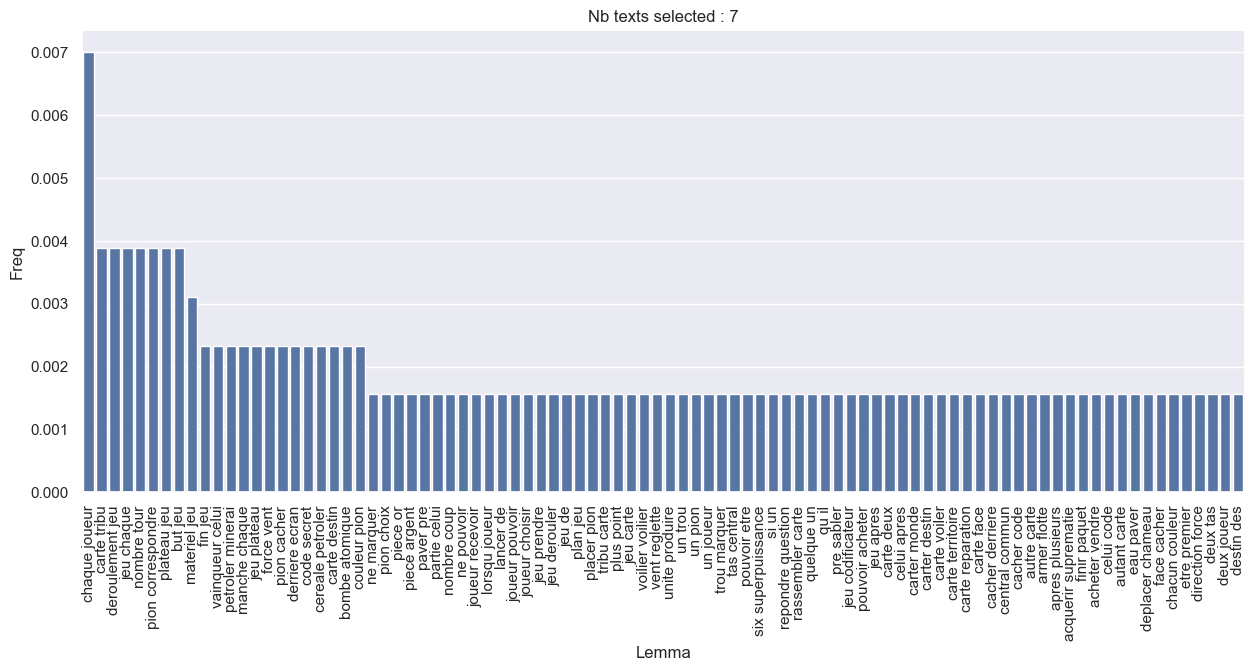

In [77]:
desc_llm = describe_cluster(5, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)

cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print("Nb tokens sent :", response["prompt_eval_count"])
print(response["message"]["content"])

### Cluster 0

**Focus sur l'expansion, la construction et la gestion de ressources**

Unigrams/bigrams
- tuile | alimenter maison 
- alimenter eau
- statuette
- coût construction

**Public**
- Jeunes, famille

Nb texts : 60 60
Description embeddings completed
Distance descriptions :  [0.20272368 0.21572685 0.22123808 0.22998114 0.23860164 0.24297642
 0.24345323 0.2445885  0.24663901 0.24985568]
CENTER DESC : Les joueurs débutent avec une main de 5 cartes. Ils joueront à tour de rôle, dans le sens des
aiguilles d'une montre. Durant son tour un joueur : - Pioche deux cartes. - Joue autant de cartes de
sa main qu'il le souhaite (cartes territoire, adversaire, épreuve ou carte spéciale.) - Affronte un
adversaire déjà en jeu ou tente de conquérir un territoire adverse. - Joue des cartes de renfort sur
des cartes "adversaire" ou "territoire". Une fois son tour terminé, il défausse des cartes de sa
main pour revenir à 5 cartes s'il lui en reste plus. S'il atteint 15 points de prestige, il peut
affronter Maletar. S'il le bat, il remporte la partie. Dans le cas contraire, il perd une carte de
prestige (et donc des points) et la partie suit son cours ... 

Nb words: 3435
3
Nb tokens: 5377
Voici une an

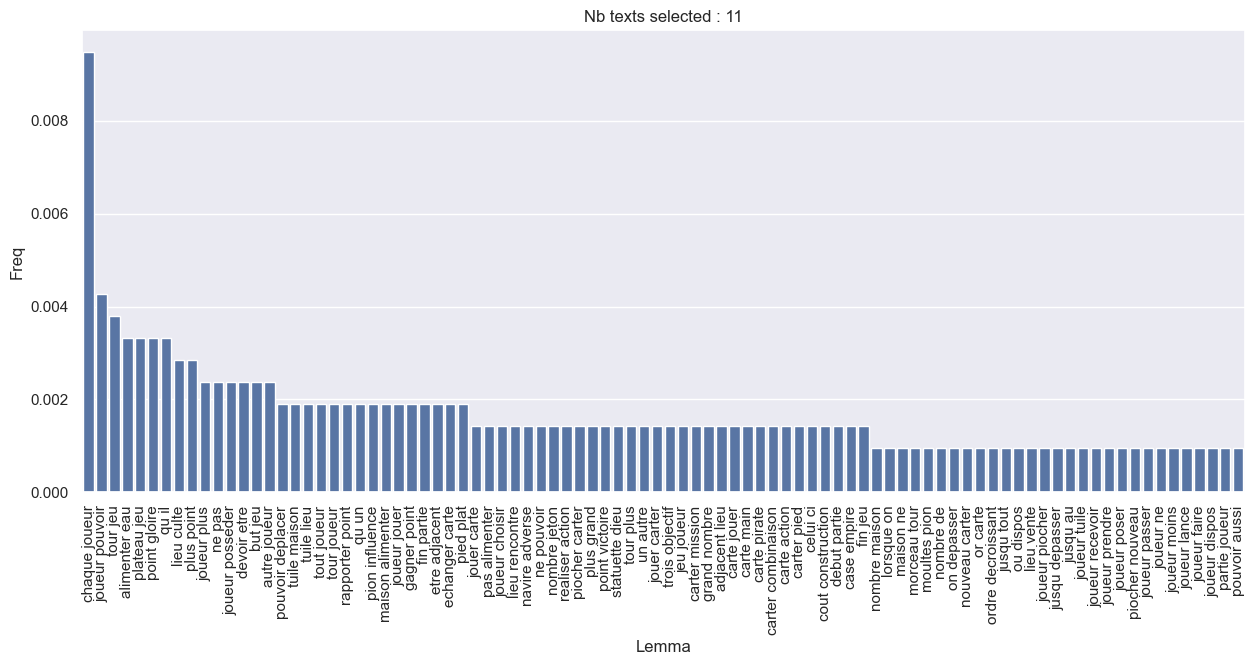

In [78]:
desc_llm = describe_cluster(0, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 1

**Themes**
- Vote (politique)
- Collection des ressources (trésors), exploration

Nb texts : 73 73
Description embeddings completed
Distance descriptions :  [0.20303365 0.20456675 0.21646404 0.2256924  0.23539706 0.24669978
 0.25415817 0.25593473 0.25854481 0.26043032]
CENTER DESC : But du jeu : Pour gagner, il faut se débarrasser de toutes ses cartes ... Au départ on distribue 5
cartes à chaque joueur Vous avez le droit de ne bouger qu'un batonnet pour pouvoir vous défausser
d'une de vos cartes (et ainsi en reproduire le schéma), sinon vous passez votre tour et vous
repiochez une carte. Matériel du jeu - 55 cartes - 5 batonnets 

Nb words: 2384
2
Nb tokens: 3793
Voici une analyse générale des descriptions de jeux et les mécaniques communes :

**Mécaniques :**

1. **Collecte de cartes ou objets** : Les jeux "Sphinx" et "Porcelaine" impliquent la collecte de cartes ou objets pour marquer des points.
2. **Déplacement sur un plateau** : Le jeu "Marco Polo" utilise un plateau pour déplacer des chameaux et dépenser des cartes Marchandise et Chamelier.
3. **Jeu de stratég

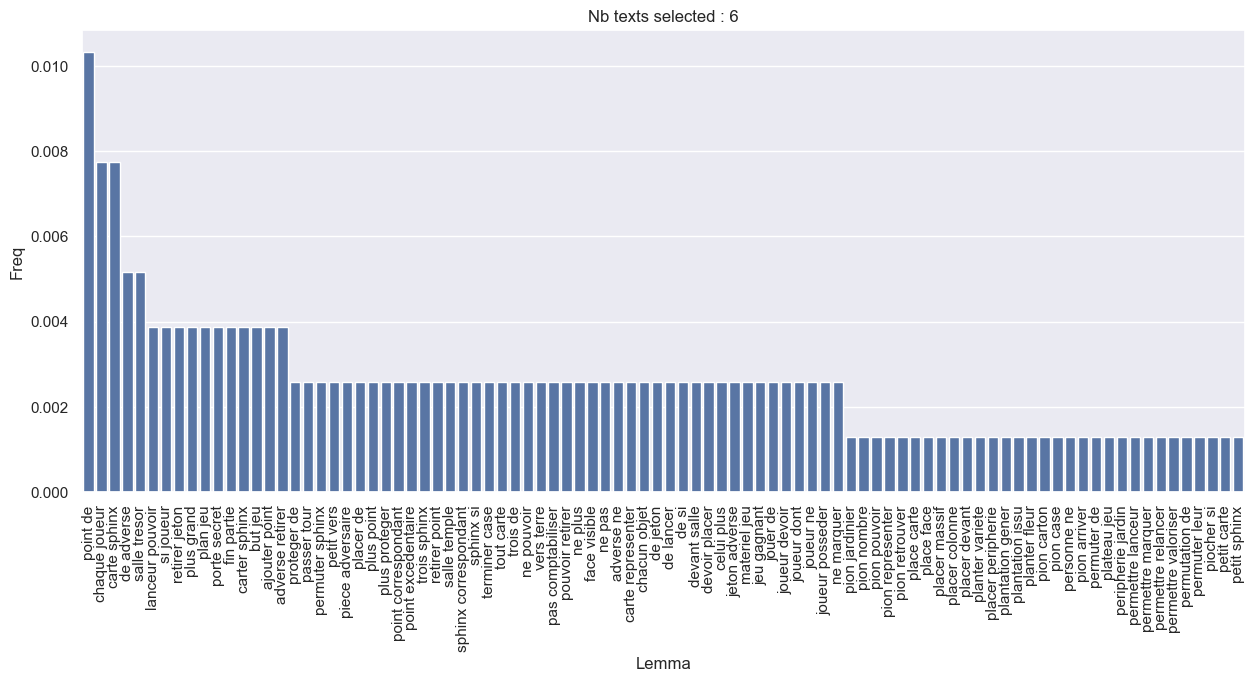

In [ ]:
desc_llm = describe_cluster(1, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 2

**Complexité**
- jeux qui peuvent être **longs** (30min à plusieurs heures) avec des règles **complexes**

Nb texts : 79 79
Description embeddings completed
Distance descriptions :  [0.22432121 0.22643105 0.24057101 0.24222448 0.24357633 0.24462828
 0.24533993 0.24889183 0.25233891 0.25819907]
CENTER DESC : Le principe est basé sur le "Stop ou encore". C'est-à-dire que vous allez accumuler des cartes pour
augmenter leur valeur mais qu'il va falloir les vendre avant qu'un évènement impromptu n'arrive. Du
coup, qu'est ce que vous faites ? Vous piocher encore au risque de perdre la moitié de ce que vous
avez accumulé ou vous voyez à court terme et vous vendez maintenant ? Surtout que votre principal
adversaire à bien vu que vous aviez une carte trésor qui l'intéresse et qu'il va peut-être vous la
voler au tour prochain.. En gros, vous allez avoir sur la table une pioche pour faire des fouilles
(avec du hasard dedans), un marché pour échanger des cartes trésors de votre main avec des cartes
visibles, une pyramide à explorer et un marché pour vendre toutes vos trouvailles. À votre tour,
vous all

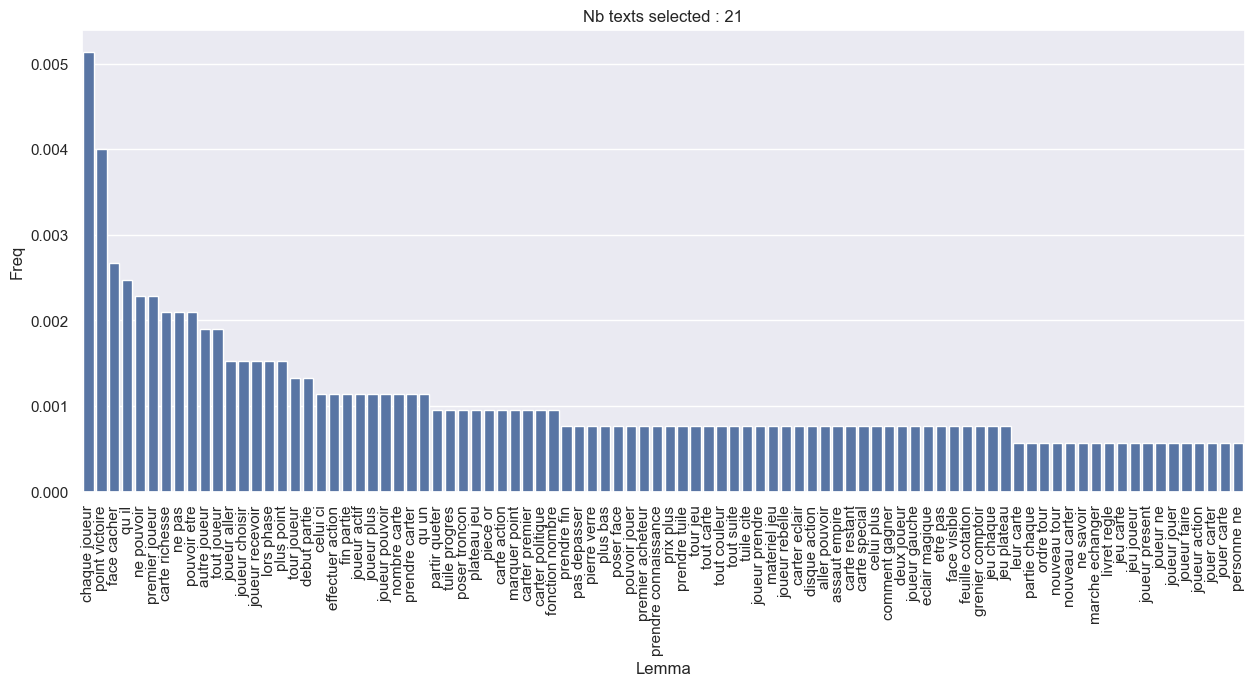

In [79]:
desc_llm = describe_cluster(2, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 3 ? 

- Plusieurs phases (préparation, déplacement)

**Common themes**
- Jeux de chasse avec la collection des objets
- Jeux-détectives

Nb texts : 92 92
Description embeddings completed
Distance descriptions :  [0.18951991 0.20372958 0.21130215 0.22123449 0.22203163 0.22612976
 0.22933002 0.23204989 0.23302164 0.23614204]
CENTER DESC : But du jeu Chaque joueur incarne un chevalier qui essaie de faire passer sous son influence des
châteaux afin d’être le plus puissant du pays. Déroulement du jeu Par des jets de dés, il faut
réaliser des combinaisons de haute valeur (brelans, carrés, etc.). Ainsi, il sera possible de
contrôler des châteaux, de remporter des tournois et de gagner des cartes action. Les châteaux et
les tournois permettent de se rapprocher de la victoire. Les cartes action permettent de protéger
des châteaux, de changer les valeurs des dés, d’avoir des lancers supplémentaires… A chaque tour, on
essaie donc de gagner des cartes en lançant les dés. On peut aussi attaquer un adversaire pour lui
prendre une carte, mais celui-ci peut se défendre en essayant de réaliser une meilleure combinaison
aux dés. Fin du j

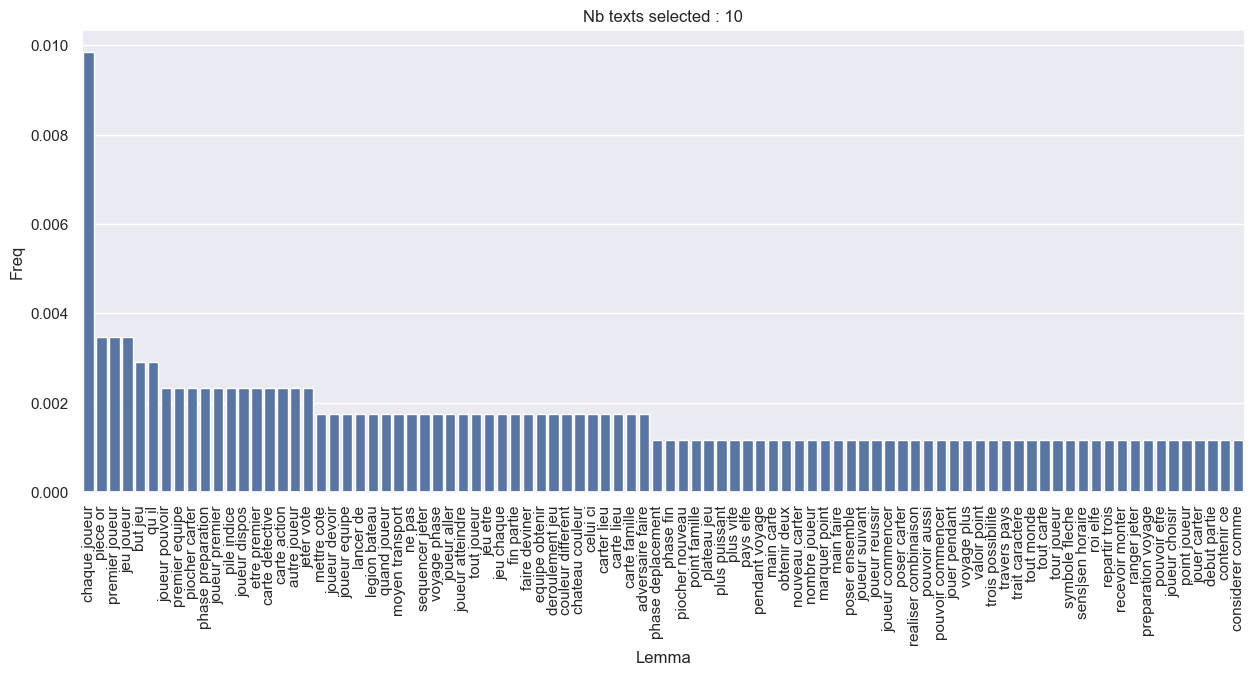

In [80]:
desc_llm = describe_cluster(3, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 4 

**Mécaniques**
- Collecte, placement ou évaluation de cartes ou de pièces.

**Publique**
- Jeune et OK pour la publique plus large

Nb texts : 74 74
Description embeddings completed
Distance descriptions :  [0.21268547 0.21715858 0.22229496 0.22544798 0.23274811 0.23473014
 0.23664069 0.23934928 0.25010717 0.25513615 0.25616237 0.25781763
 0.25839132 0.25874425 0.25924879]
CENTER DESC : Matériel : 56 cartes à jouer 7 familles de cartes de couleur 28 pions blasons (4 par joueur) 11
cartes en plus pour les variantes But : obtenir le maximum de points sur 3 manches, en faisant des
plis et à l'aide des blasons. Les points se comptent en fonction de la valeure des cartes et des
couleurs "blasons" face visible, possédés par le joueur. Préparation : chaque joueur prend une
couleur (8 cartes, identiques pour tous les joueurs), et les 4 blasons correspondants. Puis tous les
blasons sont mélangés face cachées, et chaque joueur en prend 3 devant soi, dont 1 qu'il retourne
face visible. Les blasons restants forment la pioche. Déroulement : Un par un, chaque joueur joue 1
carte.Une fois que tout le monde a joué, chacun applique

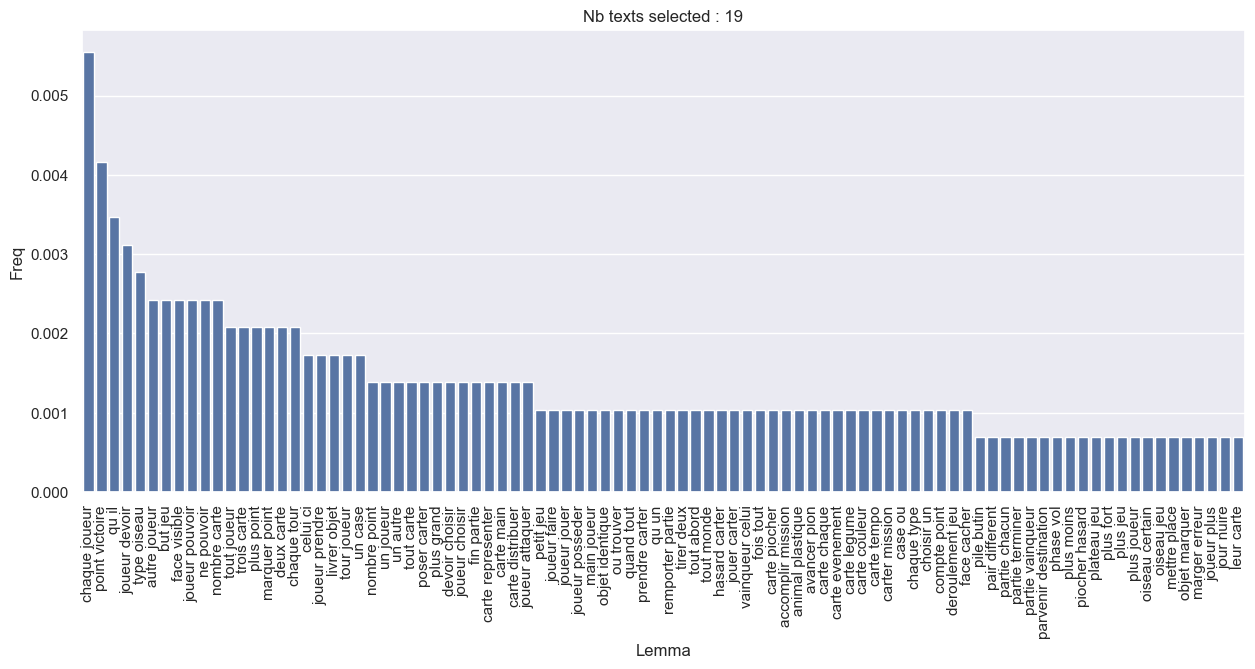

In [ ]:
desc_llm = describe_cluster(4, 1.25, 1.25, 15, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 6 

**Themes**
- Déduction/énigmes/mémorisation

Nb texts : 59 59
Description embeddings completed
Distance descriptions :  [0.21351876 0.21799289 0.21947354 0.22772977 0.2280223  0.24098993
 0.24148184 0.2423613  0.24787925 0.25596503]
CENTER DESC : Chaque joueur, à son tour, va poser une carte sur la table, construisant peu à peu une aire de jeu.
Quand un joueur pose une carte identique à une autre déjà placée et qui se trouve sur une même ligne
ou une même colonne; il capture les cartes situées entre chaque. Il arrive donc que des "lots" de
cartes soient ainsi coupés les uns des autres. Quand ceci arrive (suite à une capture), les joueurs
ne pourront plus tenter de nouvelles captures tant que toutes les cartes du jeu ne sont pas à
nouveau connectées. Sur chaque carte Dweebies, se trouve indiqué sa fréquence en jeu. La partie se
termine quand les joueurs ne peuvent plus placer de nouvelles cartes. Le joueur ayant capturé le
plus de cartes remporte la partie. Matériel : - 54 cartes (comprenant 27 Dweebies différents) - 1
règles de j

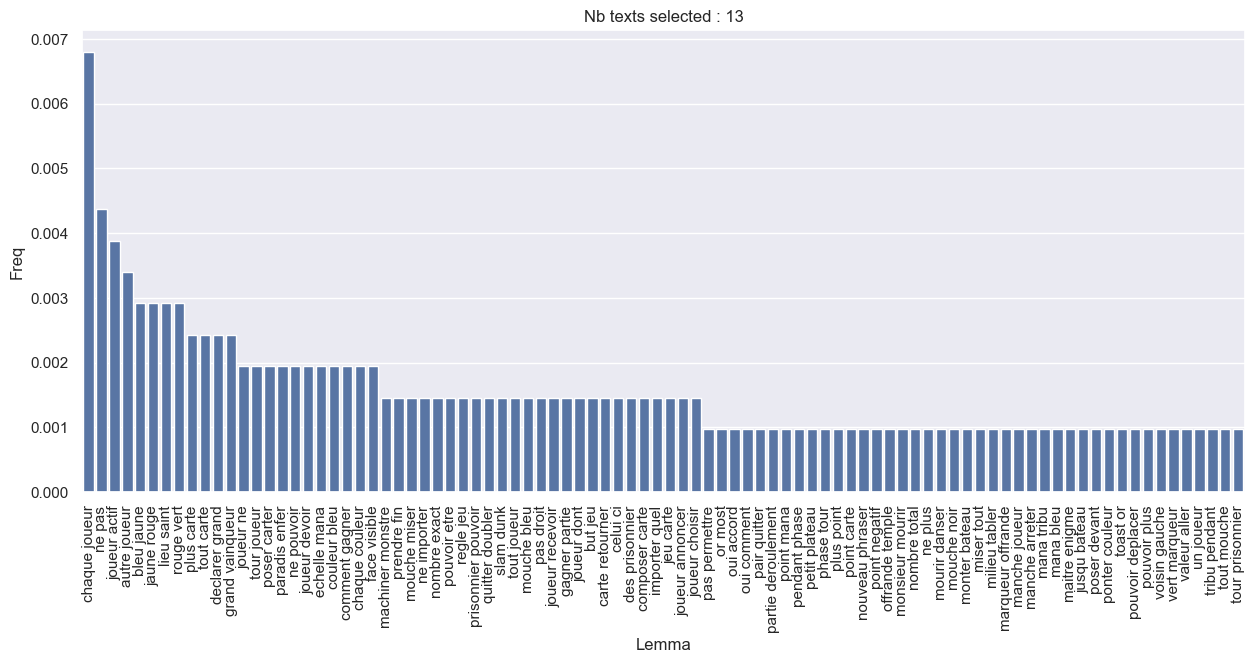

In [ ]:
desc_llm = describe_cluster(6, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 7 ?

**Mécanique**
- Planification, certains jeux sont ***longs***

**Bonne visualisation** (cartes, personnages)

Nb texts : 94 94
Description embeddings completed
Distance descriptions :  [0.20679064 0.21770986 0.22390153 0.23010941 0.24003983 0.2432188
 0.24365606 0.2461986  0.25572302 0.26514138 0.26581836 0.26774966
 0.26852028 0.26868378 0.27008872]
CENTER DESC : Chaque joueur fait partie de l'équipe des Héros ou des Zombies. Les héros sont 4 au total, et pour
gagner doivent remplir les conditions d'un scénario (par exemple tuer 15 zombis). Les zombies
doivent l'en empêcher, ou tuer un certain nombre de héros. Chaque équipe joue à son tour, tire des
cartes événements qui vont l'aider ou pénaliser l'autre. Les héros peuvent se rendre dans des
bâtiments ou ils peuvent tirer de nouvelles cartes ou aller chercher d'anciennes cartes. Les
déplacements se font à l'aide d'un dé pour les héros, tandis que les zombis n'avancent que d'une
case mais ne sont pas bloqués par les murs. Les déplacements ont lieu sur un plateau modulaire, et
la partie est gérée par des scénarii fondés sur les grands classique

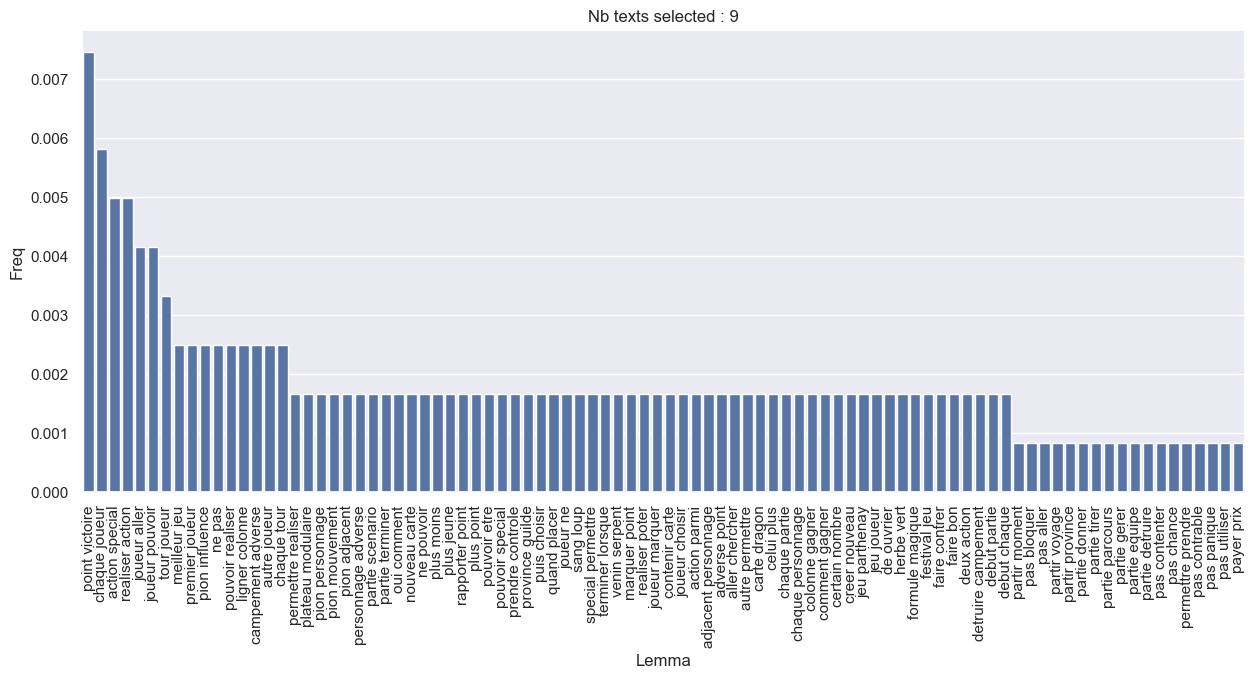

In [ ]:
desc_llm = describe_cluster(7, 1.25, 1.25, 15, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 8

**Themes**
- Collecte de qqch : trésors, dinosaures, cartes

Nb texts : 109 109
Description embeddings completed
Distance descriptions :  [0.1939349  0.2288699  0.23138758 0.2341686  0.23546044 0.24191796
 0.24283017 0.24407984 0.24920063 0.25076174]
CENTER DESC : But du jeu Les joueurs se glissent dans la peau de chasseurs de trésors et essayent, durant la
partie, de récolter de précieux trésors et de céder des trésors maudits aux autres joueurs. A la fin
du jeu, le joueur qui possède les trésors les plus précieux est le vainqueur. Déroulement du jeu
Chaque joueur reçoit une carte camp et trois cartes trésors sont placées face visible au milieu de
la table. À son tour, un joueur joue une carte aventure face visible dans la rangée aventure sous
une carte trésor. Il complète ensuite sa main. La carte aventure jouée compte toujours en faveur du
joueur qui possède la carte camp de la même couleur. A son tour, un joueur ne peut jouer qu’une
carte action (échanger des cartes, rejouer, jouer face cachée...). Cette carte action doit être
jouée avant la

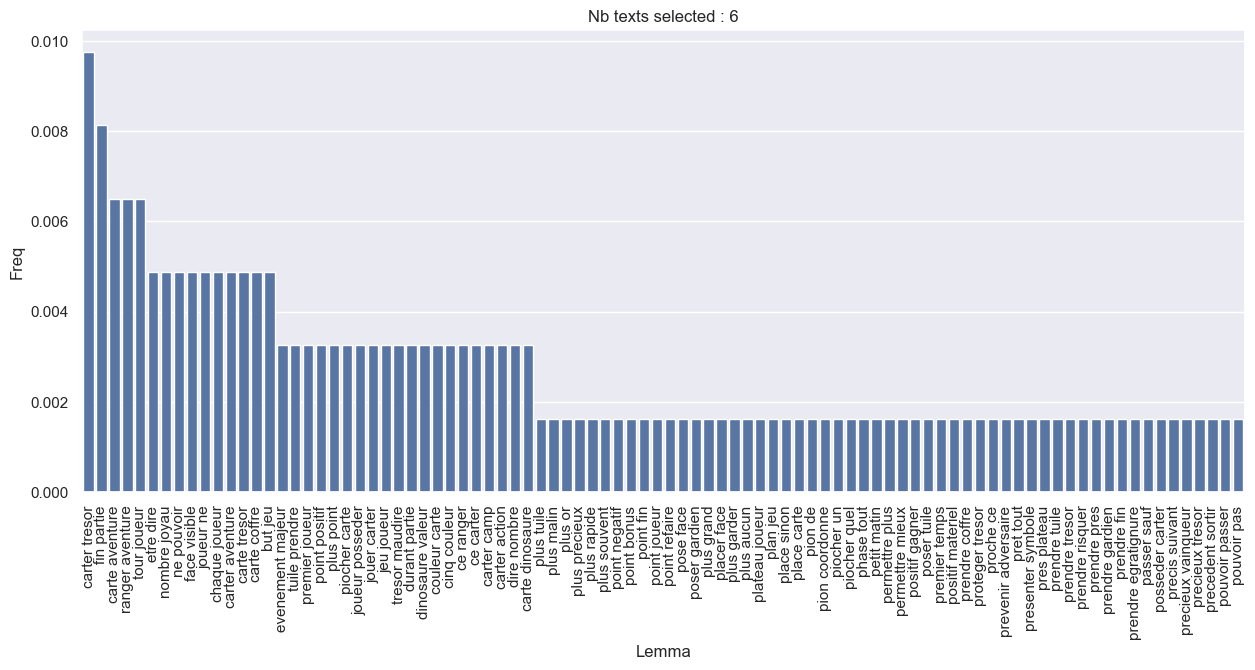

In [ ]:
desc_llm = describe_cluster(8, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 9

**Themes**
- Réponse aux questions
- Jeux basés sur forte utilisation des pions ? 

Nb texts : 71 71
Description embeddings completed
Distance descriptions :  [0.20476547 0.21794918 0.21934743 0.21961136 0.22880034 0.22974318
 0.23118273 0.23409589 0.2396153  0.24441257]
CENTER DESC : Dans cette adaptation du jeu télévisé, chaque joueur incarne le maître de jeu tour à tour. Les
autres joueurs jouent simultanément en tentant tous de répondre aux mêmes questions, de plus en plus
difficiles, pour remporter un gain (fictif, bien entendu...) de plus en plus élevé ! Pour chaque
question, 4 réponses sont proposées. Pour les aider dans leurs réponses, les joueurs ont droit à 3
jokers : le 50:50, qui permet de retirer 2 fausses réponses ; le Vote du Public, qui permet de
connaître l'avis des autres joueurs ; et enfin l'Appel à un ami, qui l'autorise à demander l'avis
d'un des autres joueurs (ou pourquoi pas d'appeler réellement une autre personne!) Une série de
questions s'achèvent lorsque tous les joueurs ont abandonné ou mal répondu (ou atteint le gain le
plus élevé !). Chac

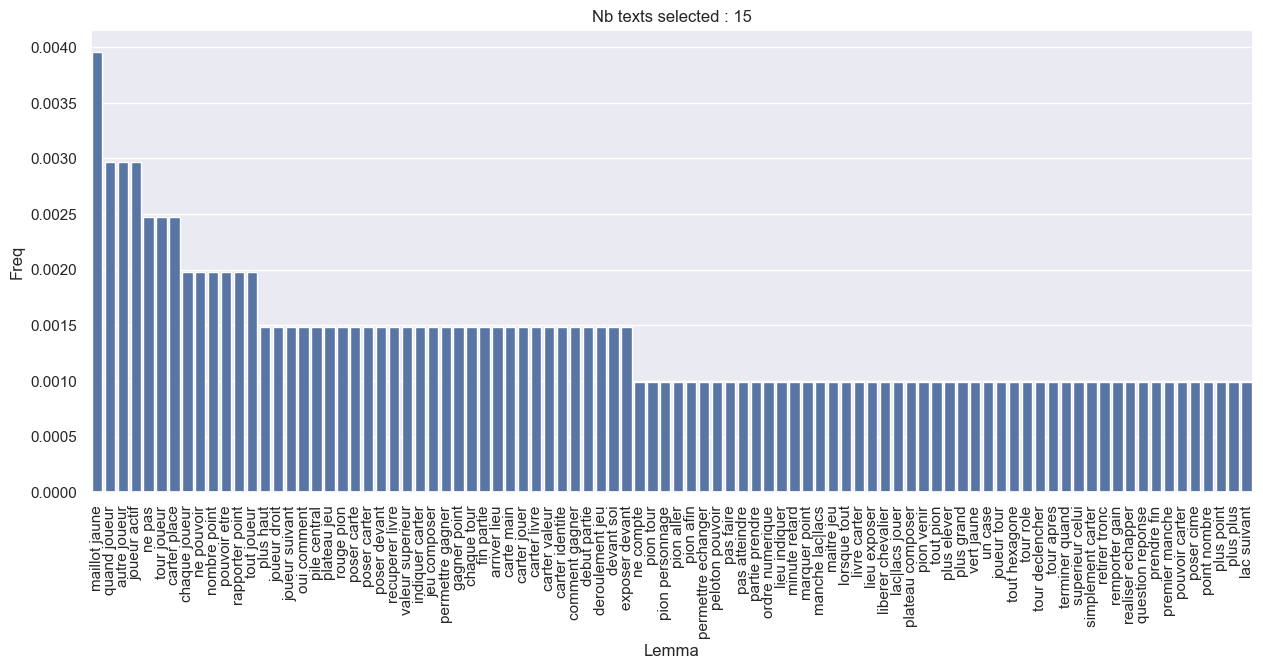

In [ ]:
desc_llm = describe_cluster(9, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 10 -> worst rated

Nb texts : 73 73
Description embeddings completed
Distance descriptions :  [0.18192966 0.20382893 0.22124665 0.22783937 0.23359083 0.23542874
 0.23597912 0.24570889 0.24738036 0.24889604]
CENTER DESC : Le but du jeu est de se défausser d'un maximum de cartes. On reçoit un paquet de cartes face cachées
au début. A son tour, le joueur retourne une carte de son paquet. Selon le dessin, tous les joueurs
doivent réagir ou non. Par exemple, si la carte retournée représente un lapin chef d'orchestre, il
faut se lever puis se rasseoir. Si un joueur à la mauvaise réaction ou pas de réaction alors qu'il
fallait faire quelque chose il ramasse toutes les cartes. Si plusieurs joueurs sont dans cette
situation, ils partagent le paquet. Puis on passe au joueur suivant. Quand un 1er joueur n'a plus de
carte, il a le droit d'induire les autres en erreur, de faire le mauvais geste ou de réagir alors
qu'il ne fallait pas. Quand un deuxième joueur a terminé son paquet, celui qui a le plus de cartes
dans s

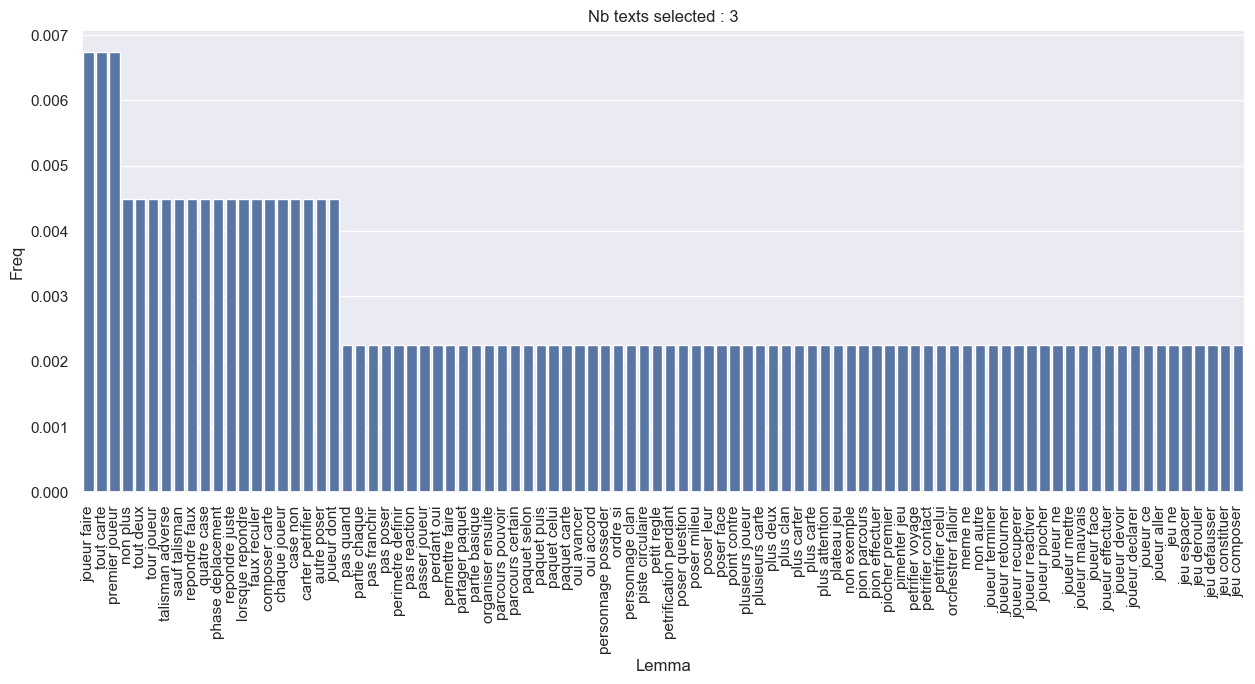

In [ ]:
# desc_llm = describe_cluster(10, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_real, comment_lemmatized, comment_real, comments=False)
# #print("Games selected", cluster_desc.shape[0])
# cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
# cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

# print("Nb words:", calc_nb_words(cluster_desc["Description"]))
# response=call_model_by_batch(cluster_desc_batched, "descriptions")
# print(response["message"]["content"])

### Cluster 11 ?

**Themes**
- Capture/défense de territoire, déplacement
- réponse/question est aussi présent

Nb texts : 93 93
Description embeddings completed
Distance descriptions :  [0.18777578 0.19167327 0.19930877 0.20185912 0.21853961 0.21903072
 0.22079473 0.22116517 0.22267226 0.22353088]
CENTER DESC : But du jeu : Obtenir le maximum de "+" à la fin de la partie. Le jeu se déroule en une succession de
manches, composées de tours. À chaque tour, un joueur devient donneur. Il prend autant de cartes que
de joueurs et va les répartir successivement en retournant les cartes les unes après les autres.
Chaque joueur recevra donc une carte. Le donneur en choisira une pour lui parmi les cartes prises.
Effet des cartes : -les cartes "+" sont immédiatement ajoutées aux cartes gagnées. -les cartes avec
des chiffres sont conservées face visibles. (certaines ont des "+") -D'autres cartes ont des effets
spéciaux : tirage d'une nouvelle carte, veto (refuser une carte ultérieurement), défausse (la
dernière reçue, obligatoirement !) ou encore 13->18 qui augmente le "plafond". La manche s'arrête
dès qu'u

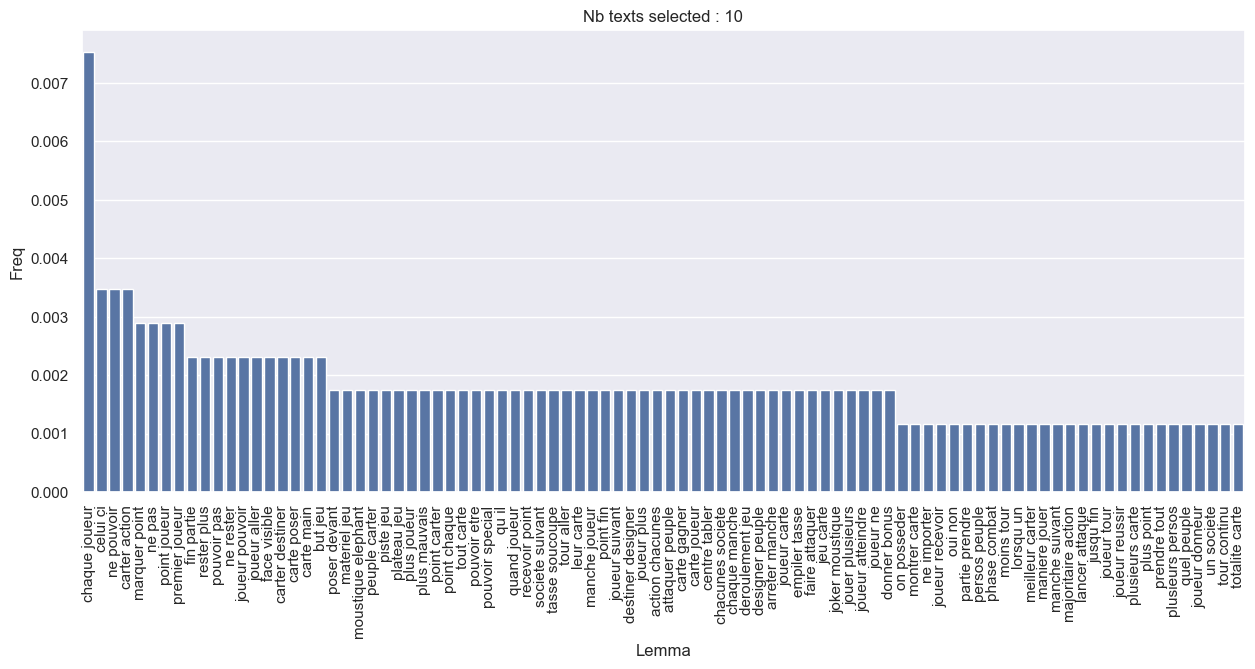

In [ ]:
desc_llm = describe_cluster(11, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 12

**Common theme**
- Construction / rénovation
- réponse/question présent

Nb texts : 69 69
Description embeddings completed
Distance descriptions :  [0.22637673 0.22735289 0.23004573 0.23594649 0.23937765 0.2502746
 0.2519911  0.25379297 0.25577618 0.26399543]
CENTER DESC : Le roi demeure dans un pays lointain. Pendant ce temps son royaume tombe dans l'anarchie et le chaos
et les princes en présence vont se battre pour étendre leurs domaines... Au départ, chaque joueur va
placer ses différents châteaux à une distance minimum de 6 cases sur le plateau de jeu, accompagné
d'un chevalier. Chaque joueur va alors essayer de former des domaines autour de ses châteaux. À son
tour, un joueur va recolter les revenus de ses mines puis effectuer au choix une des 2 actions
suivantes: - Vendre une de ses cartes pouvoir au marché pour un prix fixé. - Jouer une de ses cartes
pouvoir en payant un coût lui aussi fixé. Les effets des cartes pouvoir sont de 5 types: -Blason
vert: Poser de 1 à 3 frontières (permettant de délimiter son domaine mais également celui des
voisins) -B

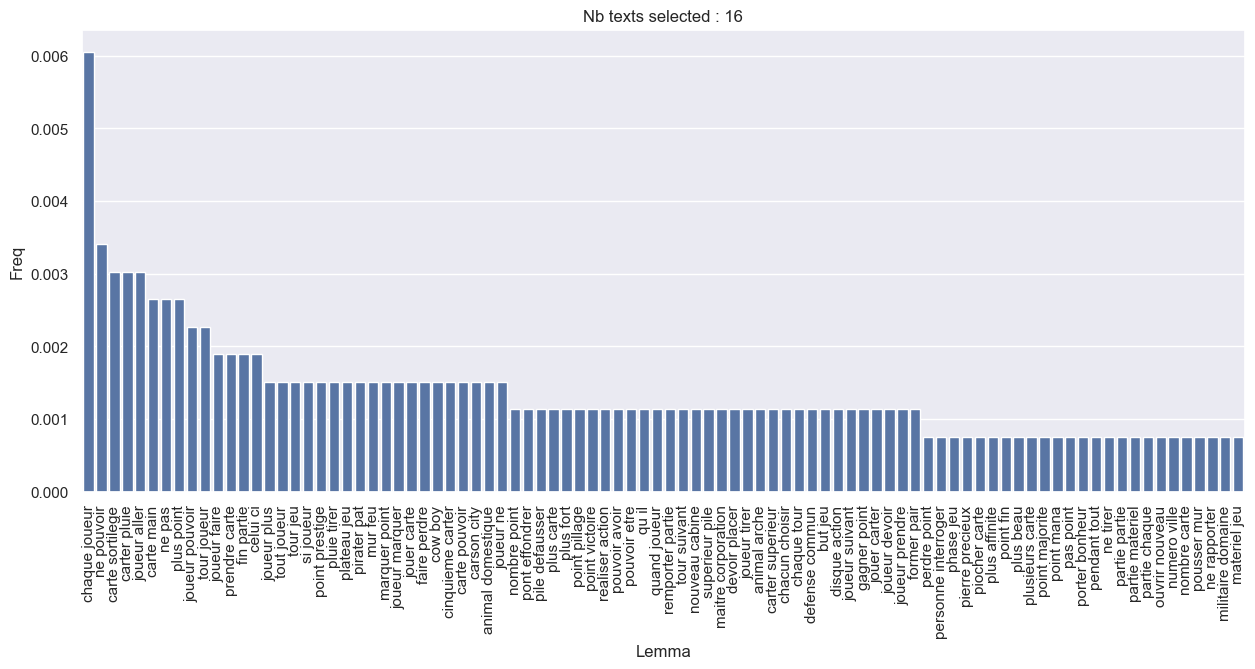

In [ ]:
desc_llm = describe_cluster(12, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 13 ? 

Nb texts : 83 83
Description embeddings completed
Distance descriptions :  [0.21433614 0.22672193 0.2313153  0.24203393 0.24440791 0.24592535
 0.24853752 0.24855008 0.25042939 0.25538541]
CENTER DESC : Le joueur posséde un jeu de cartes de sa couleur dont il doit se débarasser le plus rapidement
possible. Sur une carte, 6 ronds de couleurs différentes. On peut assembler 2 cartes si on peut
superposer 2 ronds de couleurs (cachés alors par la nouvelle carte et permettant alors de nouvelles
combinaisons). Les cartes peuvent être gardés en main ou posés sur la table (pour une meilleure
visibilité). Tout se fait bien sûr en simultané! La partie se termine quand un joueur pose toutes
ses cartes. Le joueur avec le plus de points gagne sachant que: - chaque carte posée rapporte 1
point - les cartes restant en main valent 1 point de malus - les erreurs coutent chacune 2 points de
malus. 

Nb words: 3617
2
Nb tokens: 5717
Voici une analyse commune pour les trois jeux présentés :

**Mécaniques co

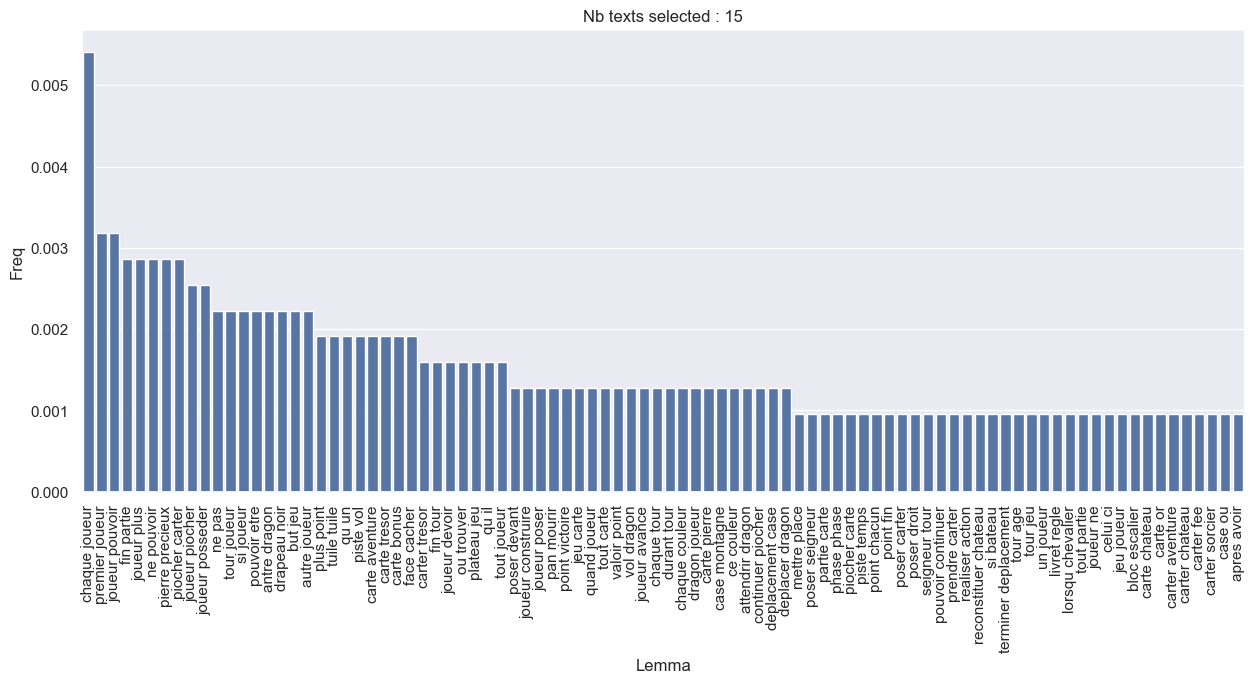

In [145]:
desc_llm = describe_cluster(13, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_real, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 14

**Mécanique**
- collecte des cartes, trésors

Nb texts : 95 95
Description embeddings completed
Distance descriptions :  [0.20208061 0.20936159 0.21611712 0.22422478 0.22424131 0.2247494
 0.22559656 0.22606889 0.22733754 0.2323287 ]
CENTER DESC : Chacun leur tour, les joueurs piochent 5 cartes et les jouent. Ils améliorent leur deck
progressivement en achetant des cartes Action et Champion issus d'une ligne centrale (le marché).
Les cartes offrent des bonus d'or (pour les achats) ou de points de combat qui permettent d'attaquer
l'adversaire et d'assomer ses Champions. Le premier joueur à mettre l'autre à 0 gagne la partie.
L'utilisation des Decks de Héros est recommandée et permet de varier les parties en changeant les
decks de départ des joueurs. Il existe également 5 Booster pour les Deck de Héros, ils sont à 4€
chacun. 

Nb words: 3056
2
Nb tokens: 4784
**Résumé des descriptions**

Les jeux présentés sont variés et se distinguent par leurs mécanismes de jeu, leurs objectifs et leurs caractéristiques. Voici un résumé rapide de c

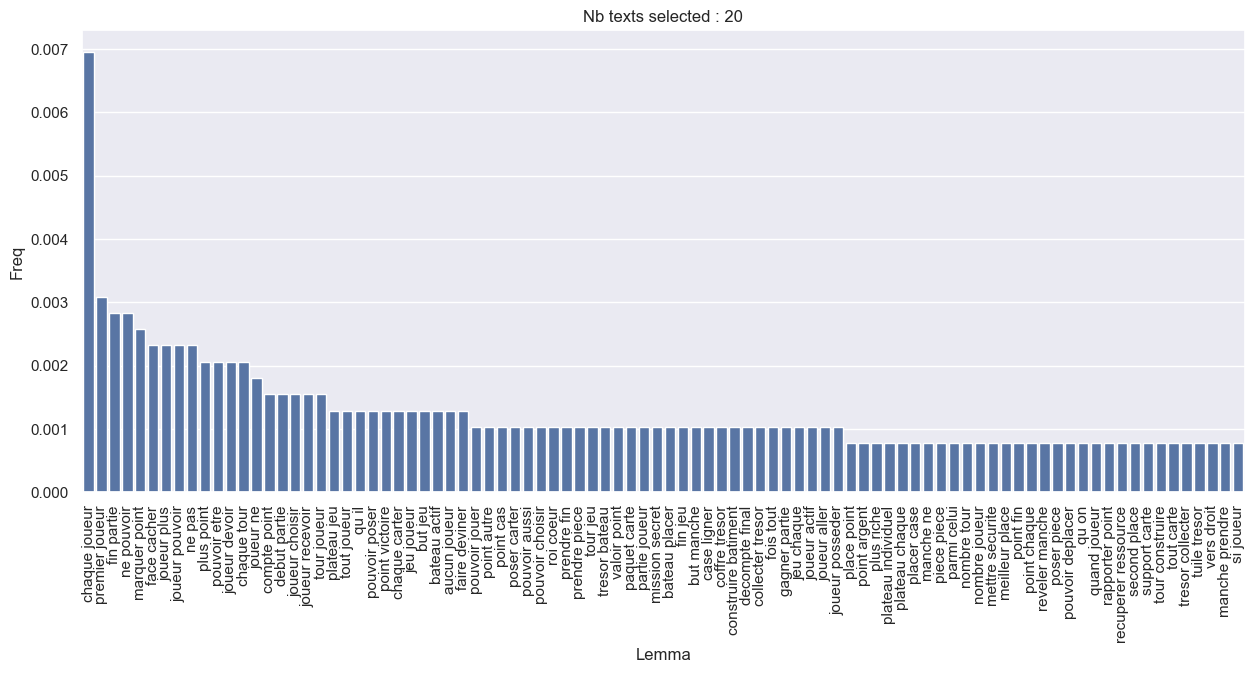

In [ ]:
desc_llm = describe_cluster(14, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 15

**Themes**
- coopération est probablement importante
- planification & gestion des ressources
- prendre des cartes aléatoirement pour l'action

Nb texts : 99 99
Description embeddings completed
Distance descriptions :  [0.22891081 0.2377024  0.23795484 0.23893495 0.24721321 0.25133022
 0.25224008 0.25281517 0.25546634 0.25624473]
CENTER DESC : Contenu de la boîte : - Un plateau de jeu représentant un circuit (type je de loie) en forme de
terrain de foot. - un dé, - 4 pions joueur, - 4 plaquettes Calcul des scores, - des billets de
banque, - des cartes joueurs Nationaux, Étrangers et Internationaux, - des cartes Euromatch, - des
cartes Chance, - des cartes Action. Une partie de déroule en deux phases. Dans la première phase,
les joueurs démarrent sans carte mais avec une somme d'argent. Les joueurs circulent librement sur
le circuit en forme de terrain de foot. Des cases leur permettent de piocher des cartes Chance,
Action, d'acheter des cartes Joueur avec leur argent, ou d'autres événement tels que payer une somme
d'argent, en recevoir, rejouer... Les cartes Joueur que vous acheter ont un prix d'achat et un prix
de revente (pl

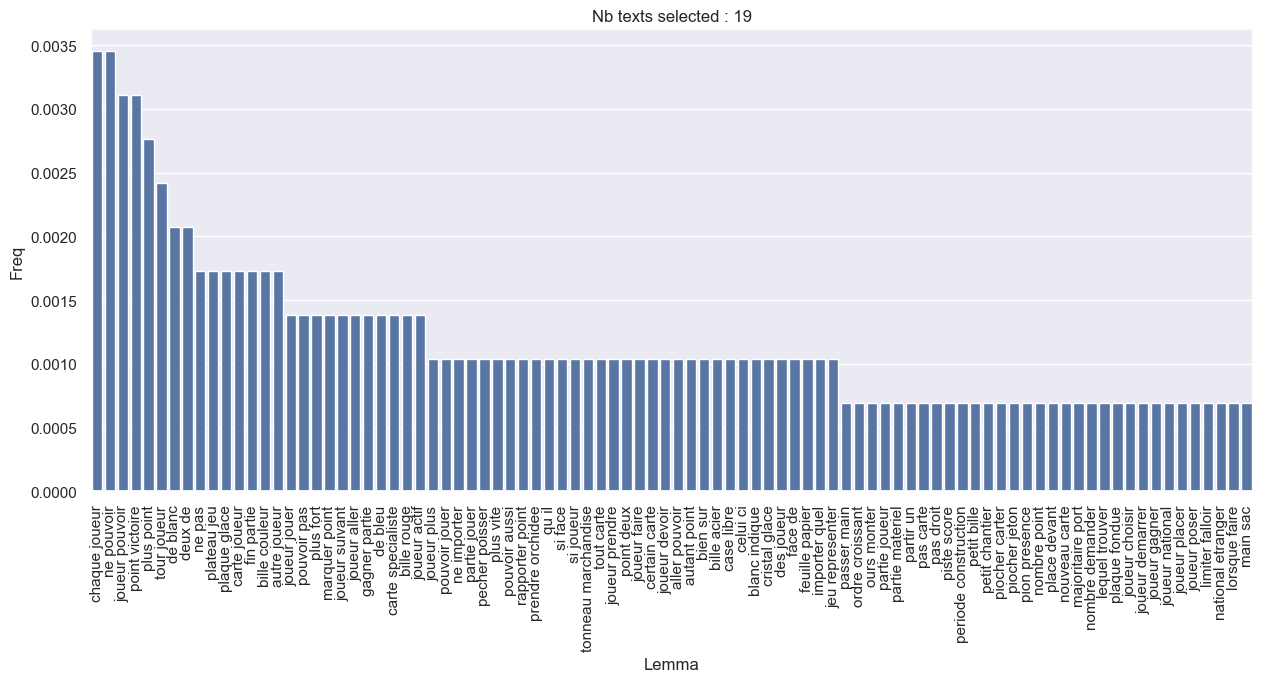

In [ ]:
desc_llm = describe_cluster(15, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 16

**Mécanique**
- gestion des ressources
- tactique
- Présence d'aléatoire (événements)

Nb texts : 100 100
Description embeddings completed
Distance descriptions :  [0.22033576 0.22171552 0.22349395 0.22497458 0.22648087 0.22855031
 0.2298809  0.23090361 0.23132712 0.23578591]
CENTER DESC : Chaque joueur dirige une tribu de cinq personnes. À chaque tour, il va falloir les envoyer
travailler pour ramener un maximum de points de victoire. Comment on joue. À chaque tour, on prend
un ou plusieurs personnages et on les assigne à une tâche. Ils peuvent aller chercher des ressources
: de la nourriture en bons chasseurs-cueilleurs qu'ils sont, du bois, des briques, de la pierre ou
de l'or. Sauf pour la nourriture, illimitée, il n'est pas possible, pour tous les joueurs, d'envoyer
plus de sept personnes pour chaque ressource. Pour chaque personnage présent, on va lancer un dé
pour savoir combien de ressources les ils vont ramener. On obtient un point de nourriture par
tranche de 2 aux dés, 3 pour le bois, 4 pour la brique, 5 pour la pierre et 6 pour l'or. (Exemple :
J'ai 3 ouvrier

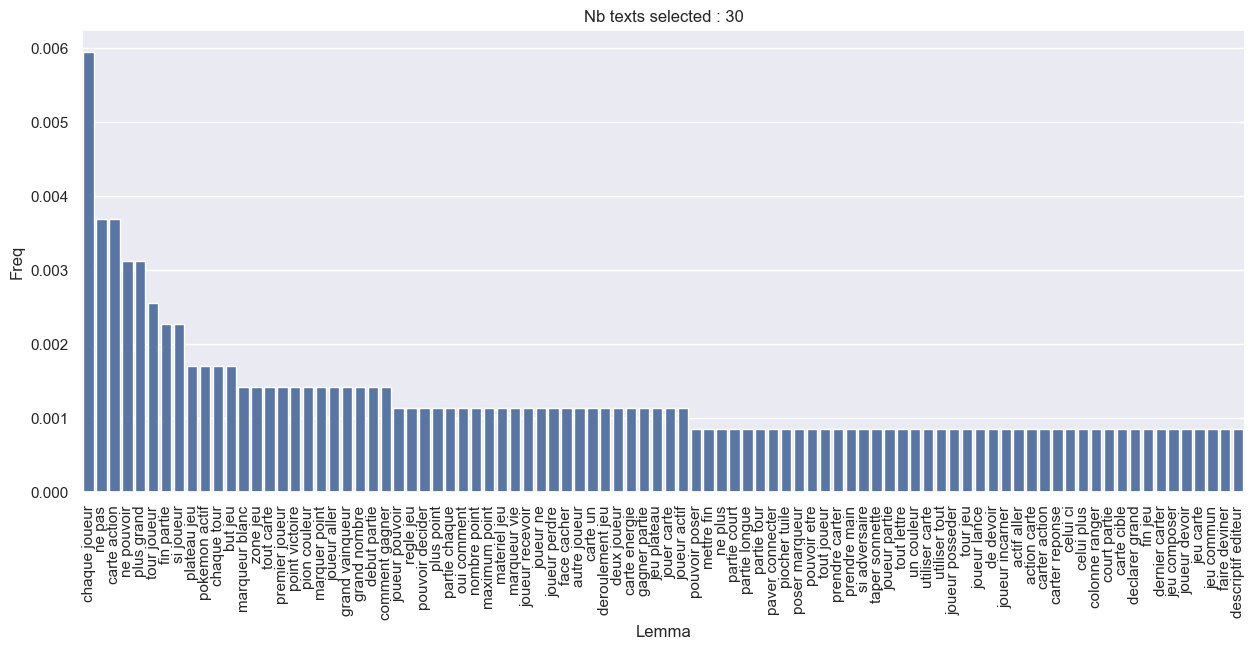

In [ ]:
desc_llm = describe_cluster(16, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 17

**Mécaniques**
- collecte des cartes

Nb texts : 81 81
Description embeddings completed
Distance descriptions :  [0.21520382 0.2302172  0.2304623  0.23707938 0.23766246 0.24755529
 0.2493768  0.251449   0.25214159 0.25249806]
CENTER DESC : Chaque joueur dirige un peuple de créatures appétissantes. Le plateau de jeu représente la table
à manger d’un géant affamé. Les joueurs vont essayer d’y propulser les créatures de leurs
adversaires afin qu’elles soient mangées. La boîte de jeu contient 57 cartes « famille », 66
cartes «action », 1 plateau de jeu, 1 règle du jeu, 1 livret de règles. 

Nb words: 2232
2
Nb tokens: 3568
Je vais essayer de résumer les descriptions en français et identifier les mécaniques clés et le public cible pour chaque jeu.

1. **La nouvelle extension du petit bac** :
 * Mécanique : Les joueurs doivent choisir des thèmes et collecter des cartes avec des lettres correspondant à l'initiale du thème choisi.
 * Public cible : Enfants et adolescents, car le jeu est conçu pour être simple et amusant

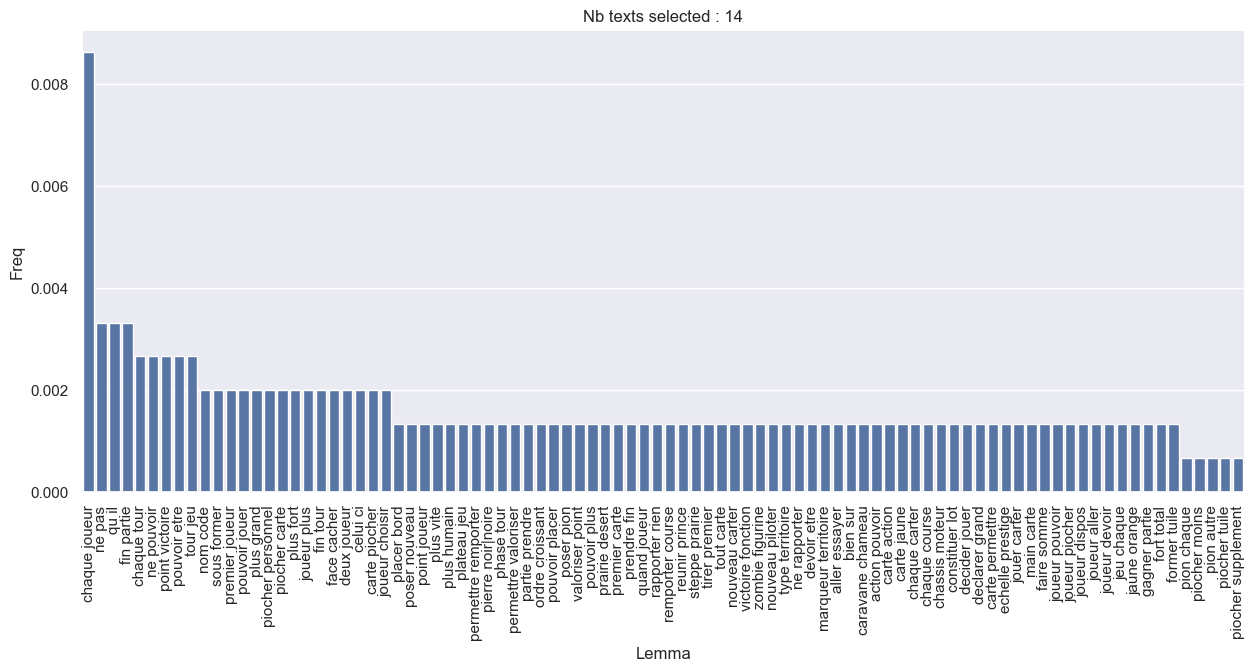

In [ ]:
desc_llm = describe_cluster(17, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 18 ?

Nb texts : 92 92
Description embeddings completed
Distance descriptions :  [0.20000043 0.21851089 0.22321592 0.23244203 0.24261713 0.245674
 0.25272311 0.25529877 0.25719289 0.26343356]
CENTER DESC : Au tour de chaque joueur, neuf cartes représentant des cadeaux sont placées sur le plateau de jeu
commun. Chacun doit alors choisir lequel de ces cadeaux il ferait à chacun des autres joueurs, puis
les trois cadeaux qui lui feraient le plus plaisir de recevoir, ainsi que celui qu’il n’aimerait
vraiment pas qu’on lui fasse. Les choix des joueurs sont ensuite révélés. Chaque cadeau apprécié par
son destinataire fait marquer des points aux deux joueurs, celui qui l’offre et celui qui le reçoit.
Un cadeau dont on ne voulait vraiment pas fait à l’inverse perdre des points aux deux joueurs. Ce
jeu est en anglais mais les textes sont simples et illustrés(une phrase en général) et sont les
mêmes pour tous les joueurs. Il suffit donc d'une traduction collective (les images aident
beaucoup). 

Nb wo

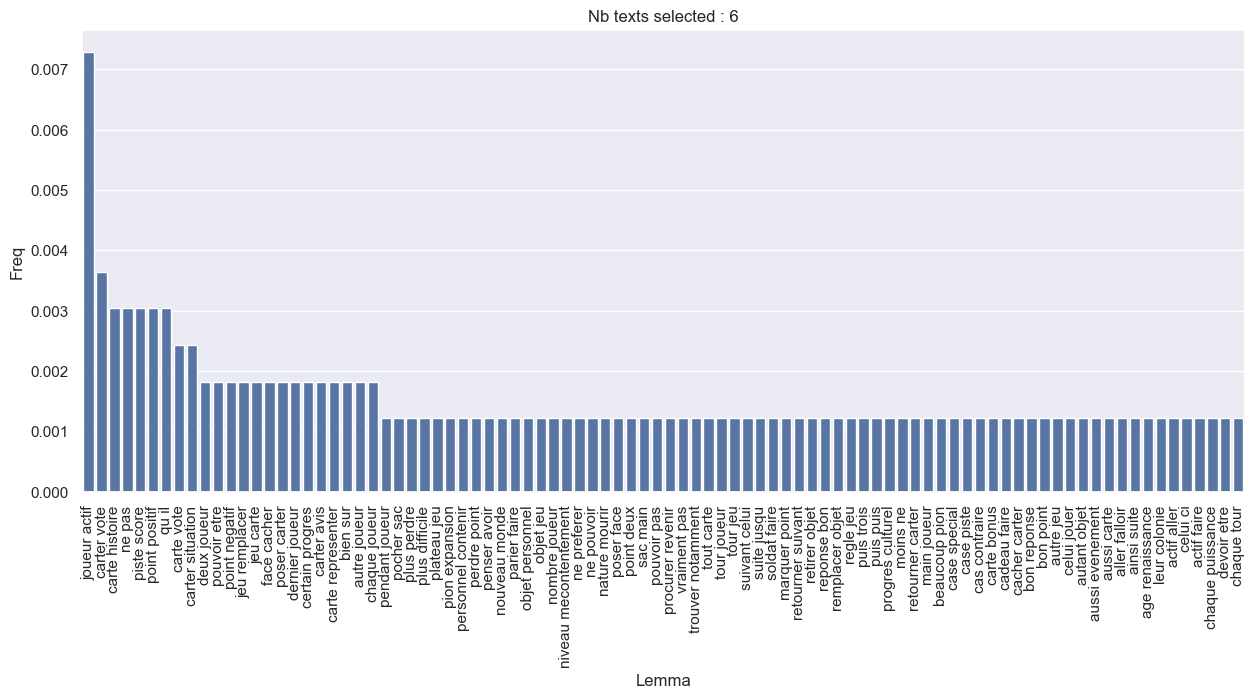

In [ ]:
desc_llm = describe_cluster(18, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 19 ?

- Collecte des ressours (cartes, jetongs), construction
- Expension de la territoire, combat
- Jeux longs

Nb texts : 68 68
Description embeddings completed
Distance descriptions :  [0.22225178 0.24399307 0.24531156 0.2518675  0.25396631 0.25411636
 0.25592505 0.25845181 0.26054058 0.26336354]
CENTER DESC : Chaque joueur mélange les 18 cartes de valeur 1 à 9 de sa couleur. À son tour de jeu, il en pioche
une au hasard et la pose à côté d'une carte déjà sur la table, ou en recouvre une de valeur
inférieure. Le premier à aligner 4 de ses cartes (5 à 2 joueurs remporte la manche. Deux manches
gagnées et la victoire est à vous. 

Nb words: 3041
2
Nb tokens: 5046
Voici une analyse des descriptions de jeux donnés :

**Thèmes communs**

* La plupart des jeux présentent des thèmes de stratégie et de planification, avec un accent sur la gestion des ressources et les décisions éclairées.
* Certains jeux présentent des éléments de compétition et de rivalité, tels que les combats ou les concours.

**Mechaniques de jeu**

* Les mécaniques de jeu les plus présentes sont :
 + La construction et la gestion

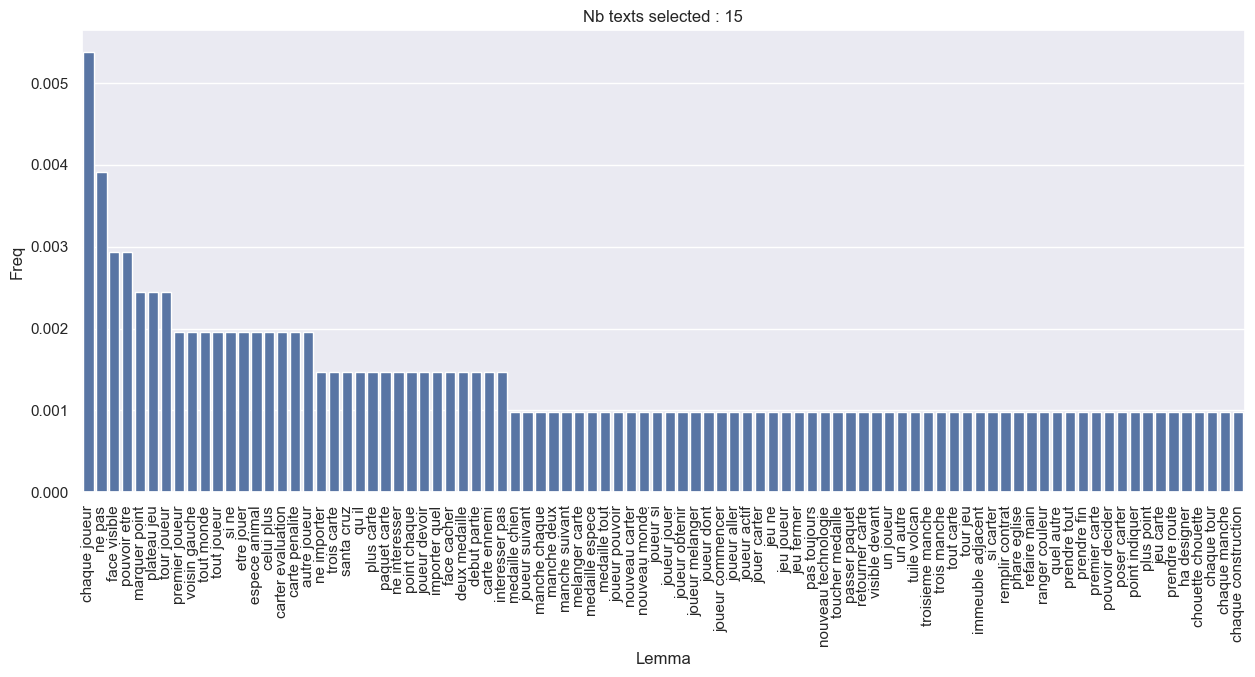

In [ ]:
desc_llm = describe_cluster(19, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 20

**Mécaniques**
- rapide
- stratégie/tactique/planification

Nb texts : 66 66
Description embeddings completed
Distance descriptions :  [0.2053368  0.21539008 0.23490487 0.23772953 0.24581671 0.24856296
 0.25246863 0.25646188 0.25910238 0.26064357]
CENTER DESC : Matériel : -un plateau de jeu, -un plateau de score, -5 pions chef de tribu, -188 boucliers (46
rouges, 46 bleus, 32 noirs, 32 verts, 32 oranges) -12 marqueurs de pays, -un marqueur d'action, -98
cartes, -deux résumés des règles. Europe, an 412. Cinq tribus vont se développer et conquérir de
nouvelles terres : les Huns, les Lombards, les Goths, les Vandales et les Anglo-saxons. Le plateau
représente l'Europe, sur une carte divisée en cases, repérées par des lettres (de A à J) et des
chifres (de 1 à 10).Le continent est divisé en 12 pays. Il y a des cases de mer, et une piste de
score entoure la carte. Chaque joueur préside à la destinée d'une tribu, et va tenter d'imposer sa
domination sur le continent. À chaque tour, les joueurs reçoivent 10 cartes. En jouant ses cartes,
le joueur va po

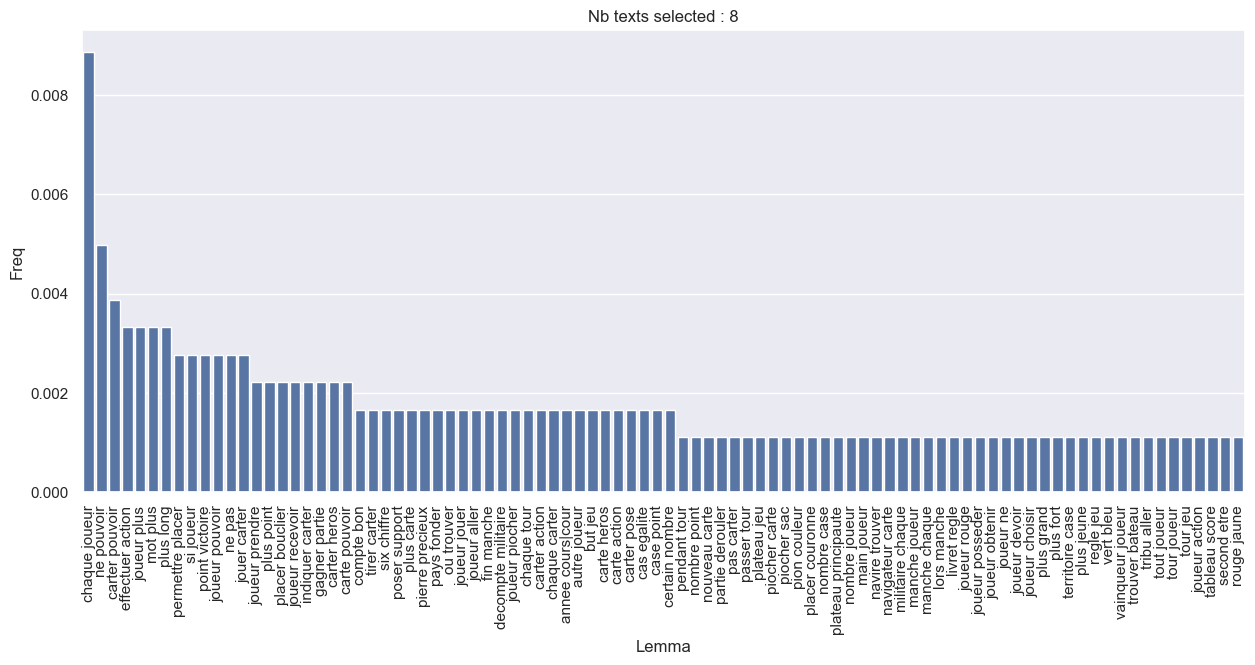

In [ ]:
desc_llm = describe_cluster(20, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 21 

- gestion des ressources
- gestion d'influence & la conquête de régions

Nb texts : 90 90
Description embeddings completed
Distance descriptions :  [0.2071919  0.22425302 0.23186143 0.24098775 0.24995078 0.25261609
 0.25300966 0.25409635 0.25975729 0.26016242]
CENTER DESC : Le jeu est constitué d'un plateau sur lequel sont posés aléatoirement en début de chaque manche 6
cubes de couleurs différentes (rouge, orange, jaune, vert, bleu, violet) qui forment un spectre de
couleurs, ainsi que 20 pions colorés à raison de 10 par joueur. Ces pions sont également piochés et
répartis au hasard et sont au nombre de 30, 5 dans chacune des 6 couleurs (il y a donc toujours 10
pions d'écartés). Le but pour chacun des joueurs est de réorganiser sa ligne de pions en fonction de
l'ordre des couleurs du spectre de couleurs. Les deux joueurs disposent de 5 cartes Action en début
de chaque manche et, à tour de rôle, vont devoir en jouer une puis compléter leur main. Ces cartes
Action ont divers effets : . intervertir les 2 extrémités de sa ligne de pions ; . intervertir 2
pions

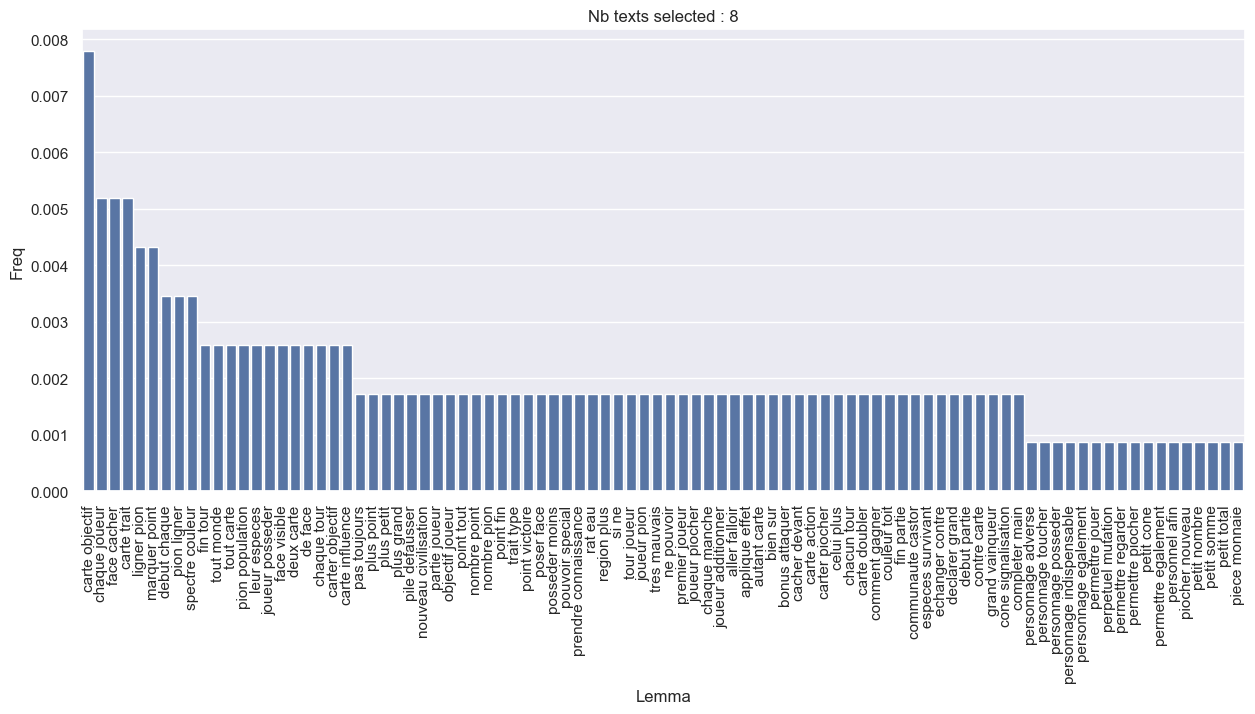

In [112]:
desc_llm = describe_cluster(21, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 22 ?
**Common themes**
- Exploration des nouveau térritoires / colonisation
- Puzzle/énigme
- échange des cartes --> coordination/coopération des joueurs?


Nb texts : 75 75
Description embeddings completed
Distance descriptions :  [0.18487697 0.18548263 0.20803619 0.21520235 0.23770166 0.23845838
 0.23937035]
CENTER DESC : Matériel . 78 cartes (1 énigme par carte) réparties en 6 catégories différentes. . 1 livret
contenant les règles du jeu et les solutions aux énigmes. . Munissez-vous d'une montre ou d'un
chronomètre, afin de calculer le temps imparti à la résolution des énigmes des cartes "Tempo", ainsi
que de feuilles de papier et de crayons. But du jeu Être le plus perspicace et le plus astucieux des
chevaliers présents autour de la table! Déroulement de la partie Le partie est composée de plusieurs
joutes consécutives. Un joueur ou une équipe remporte une joute lorsqu'il ou elle parvient à trouver
la réponse à l'énigme de la carte tirée au sort. Il y a 6 catégories d'énigmes différentes: . Les
énigmes de logique . Les énigmes d'observation . Les énigmes de chiffres . Les énigmes de mots . Les
énigmes lettrenrébus . Les énigmes de man

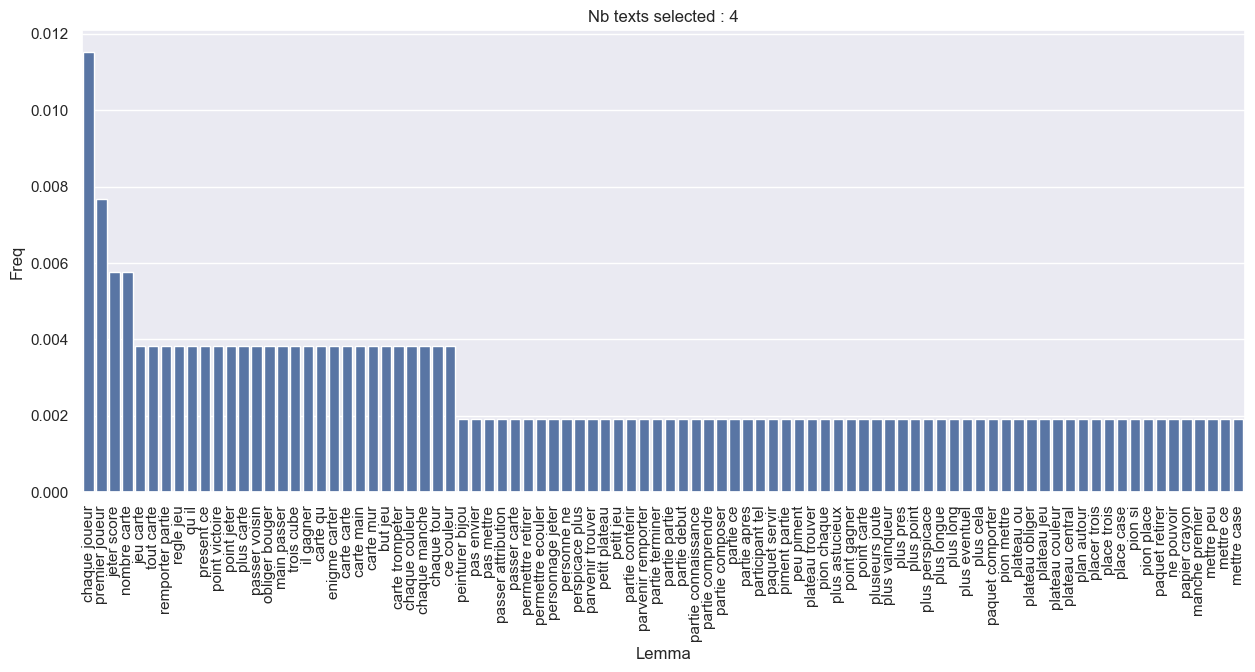

In [84]:
desc_llm = describe_cluster(22, 1.25, 1.25, 7, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 23 ?

- Accent sur la réflection

**Résumés**
1. Le jeu consiste à jouer avec un tapis, des cartes Rose et Skull, et à définir les règles de la partie, en fonction du nombre de cartes jouées.
2. "Croître" est un jeu de conquête et d'optimisation pour 2 à 4 joueurs où l'objectif est d'être le premier à atteindre 15 points de victoire.
3. Le jeu "Mystères d'Europe" consiste à utiliser des indices, des cryptographe et des billes pour résoudre des mystères en voyageant à travers l'Europe.
4. Le jeu "Billes" consiste à ranger les billes dans une matrice spécifique avec un dé et des pions de déplacement pour gagner le plus quickly possible.
5. Le jeu "Ligne de mots" consiste à trouver un nom ou une phrase dont un mot ou plusieurs ont été déformés par un jeu de mots, en atteignant la première case "Arrivée".
6. Le jeu "Dés de Règlement des Comptes" est un jeu de stratégie où les joueurs doivent gérer leur argent et leurs actions pour être le premier à atteindre 15 points de victoire.
7. Le jeu "Mafia" consiste à envoyer des héros dans les rues de la ville et des banlieues pour trouver qui a le meilleur sens de la gâchette et des affaires.
8. Le jeu "Foutrak" propose de remporter la victoire en empochant le plus grand nombre de cartes, en choisissant un adversaire pour un duel et en complétant les instructions indiquées sur la carte.
9. Le jeu "Challenge ton cerveau" consiste à affronter des défis différents pour tester ta réflexion, ta mémoire et ta rapidité.

Nb texts : 82 82
Description embeddings completed
Distance descriptions :  [0.22553461 0.22622539 0.24048499 0.24076782 0.24290684 0.24435279
 0.24545831 0.24821819 0.2488896  0.25202673]
CENTER DESC : Croître, Voyager, Récolter, Guider. Dans ce jeu de conquête et d'optimisation pour 2 à 4 joueurs,
vous incarnez un chef de tribu et tentez de faire prospérer au mieux votre peuple afin d'être le
premier à atteindre les 15 points de victoire et à l'emporter. Les dés que vous lancez se combinent
avec les choix de vos adversaires pour déterminer l'efficacité des actions. Un mode avancé est
disponible pour ceux qui auraient soif de plus d'aventures. Utilisez les pouvoirs de vos chefs de
tribu et les terrains spéciaux pour enrichir vos parties. 

Nb words: 2053
2
Nb tokens: 3187
Voici une analyse commune aux descriptions des jeux :

**Objectif** :
- Le but principal est de remporter la partie le plus rapidement possible.

**Mechaniques** :

- **Duel** : plusieurs jeux présentent un élément de

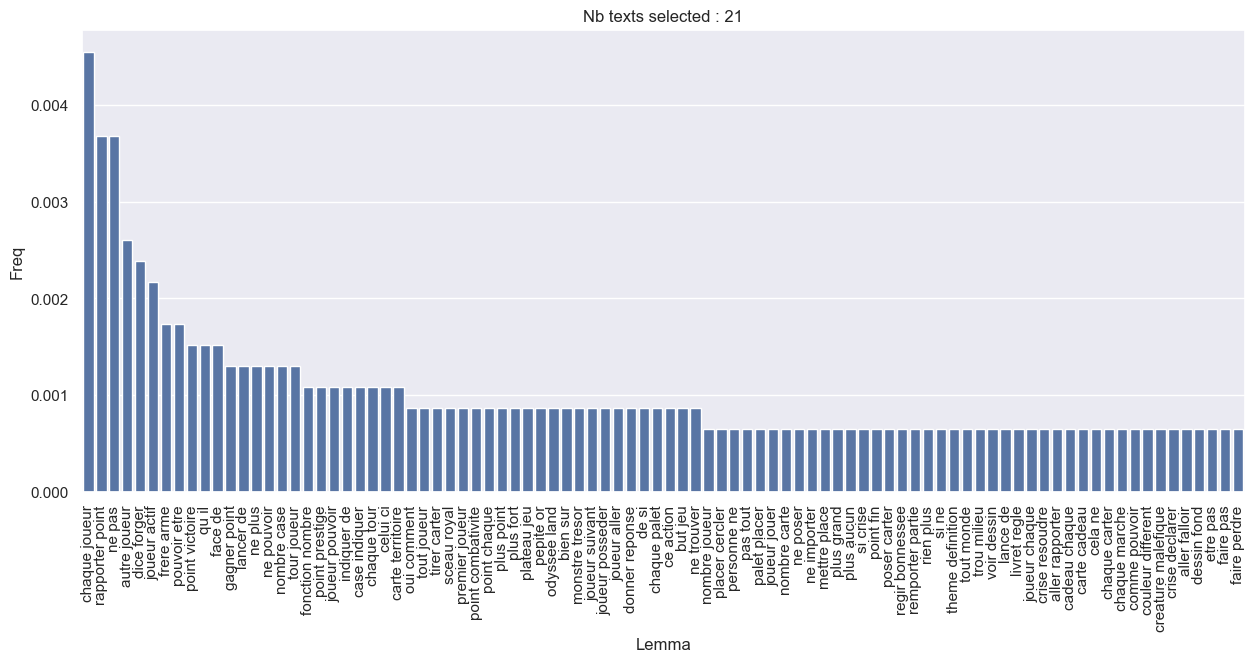

In [111]:
desc_llm = describe_cluster(23, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 24 (best rated)

**Themes**
1. Térritoire inconnue (plantétes, dinosaures, settlers) -> exploration & survie
2. Colonisation (prendre de térritoire)
3. Gestion des ressources : troupes, marchandises

Nb texts : 109 109
Description embeddings completed
Distance descriptions :  [0.23088382 0.23978711 0.25314933 0.25387749 0.25415248 0.25765831
 0.25784208 0.25914032 0.26019356 0.26223055]
CENTER DESC : Règle de base Chaque joueur se voit donner 7 cartes qu'il garde à sa discrétion et 5 cartes, faces
visibles, sont posées sur la table. Ces cartes représentent des "critères" qui vont du physique
(grand, petit...) aux vêtements et accessoire (boucle d'oreille, jean, etc...). Dès qu'un joueur
voit une personne avec l'un des "critères" de l'une des 5 cartes face visible, il en informe ses
adversaires et hop, il a gagné le droit de remplacer cette carte (la visible donc) par l'une de
celle qu'il a en main ! Forcément, vous l'aurez deviné, est déclaré "Grand Vainqueur" celui qui se
débarrasse de toutes ses cartes. Forcément, c'est lui qui aura trouvé le plus de personnes !
Variante dite "Total Mateur". Chaque joueur va recevoir 4 cartes "critères" qu'il garde à sa
discrétion. Puis, tous en 

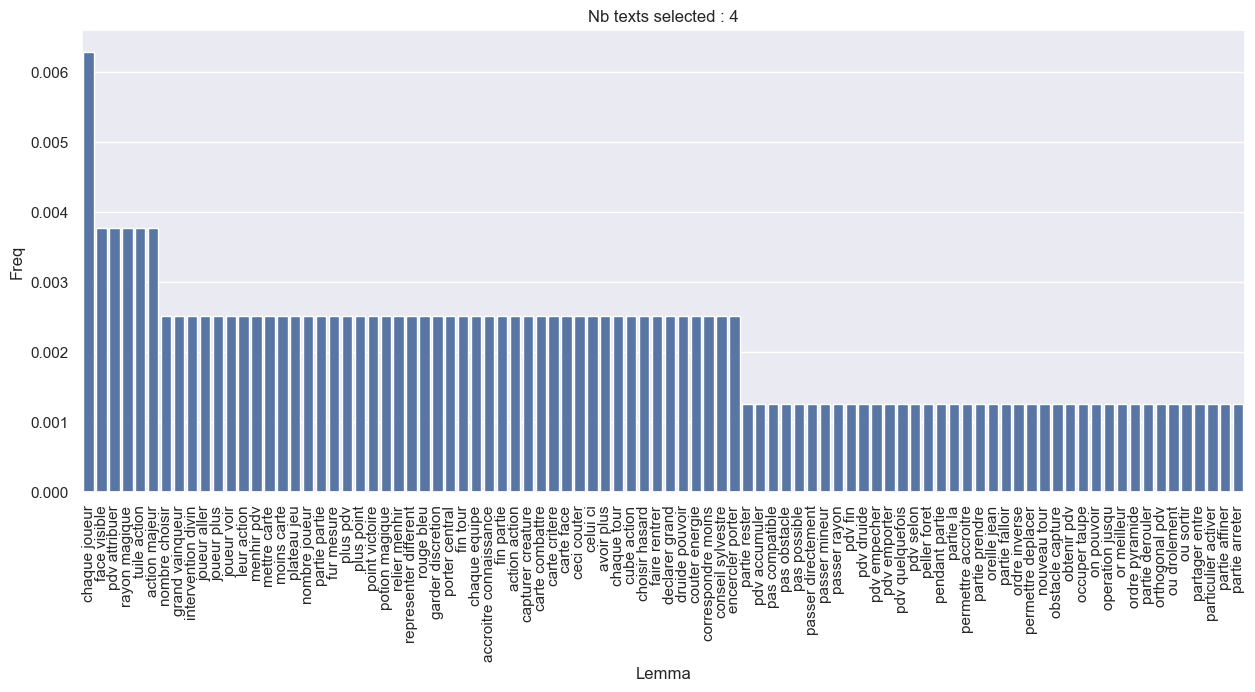

In [ ]:
desc_llm = describe_cluster(24, 1.10, 1.10, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "desc_summary")
print(response["message"]["content"])

### Cluster 25

- jeux d'échecs
- présence des batiments (construction ou atmosphère)

1. Les joueurs sont des architectes qui doivent construire leur projet de construction en fonction d'un plan distribué aléatoirement. Ils doivent également suivre les règles pour gagner des prix et distinctions.

2. Châteaux, monastères et exploitations agricoles sont édifiés dans des paysages appropriés. Les joueurs doivent déjouer les adversaires pour en retirer les meilleurs revenus.

3. Le but du jeu est de collectionner le plus grand nombre de points parmi les 200 cartes de villes ou de sites touristiques de toute l'Europe, tout en évitant les erreurs qui valent des points négatifs.

4. Dans Paper Tales, les joueurs doivent drafter des unités pour leur Royaume au fil de deux siècles, en suivant une stratégie pour remporter des points de légende et gagner le jeu.

5. Le shōgi est un jeu d'échecs japonais où les pièces peuvent être parachutées pour menacer ou renforcer la défense. Les joueurs doivent également promouvoir leurs pièces pour en bénéficier de mouvements supplémentaires.

6. Occupe-toi de tes œufs ! Le jeu consiste à trouver le demi-œuf qui correspond au dessin sur le coquetier, tout en cherchant les jetons pour les placer dans la boîte à œuf.

7. Gold Rush est un jeu où les joueurs doivent exploiter les mines et collecter des sous pour gagner le jeu. Les joueurs peuvent influencer l'ordre de choix des cartes aux enchères et construire des saloons ou faire des actions pour avancer dans la partie.

8. Cluedo est un jeu d'échecs américain où les joueurs doivent collecter des indices et des preuves pour identifier le coupable du meurtre. Les joueurs peuvent poser des cartes qui enrichissent l'affaire en cours, tout en évitant les erreurs qui valent des points négatifs.

Nb texts : 94 94
Description embeddings completed
Distance descriptions :  [0.22384534 0.22784512 0.24190443 0.24679155 0.24879102 0.24961985
 0.25362753 0.25628058 0.25773042 0.25842366]
CENTER DESC : But du jeu Chacun des joueurs tient le rôle d’un marchand cherchant à atteindre le plus haut niveau
social. A la fin du jeu, le marchand avec le plus haut statut est le gagnant. Les ex æquo sont
départagés par la fortune. Déroulement du jeu Le jeu se joue en plusieurs tours. Chaque tour se
décompose en 6 phases. Avant le premier tour les joueurs doivent d’abord mettre en place " la
boutique " (achat de cartes d’habileté aux enchères) Phase 1 : Achat de marchandises (0 à 3
marchandises pour chaque joueur). Phase 2 : Mise aux enchères puis chargement des chariots. Phase 3
: Mouvement des chariots et du messager Phase 4 : Modification des prix, ventes des entrepôts Phase
5 : Vente des marchandises livrées Phase 6 : Entretien et changement du statut social Fin de partie
Le jeu s’arrête lorsq

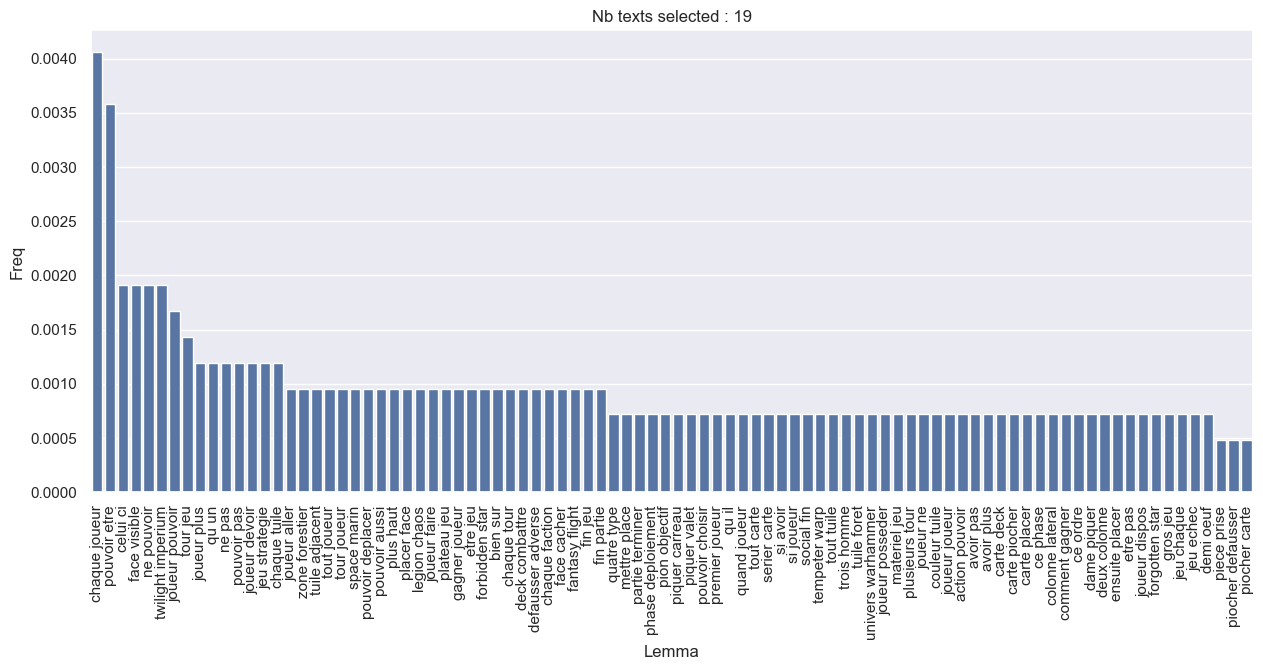

In [110]:
desc_llm = describe_cluster(25, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 26 -> close to best rated cluster

1. **Règle du jeu** : Un jeu où les joueurs doivent capturer des pièces colorées et formes particulières en tirant des cartes. Chaque joueur a un tas de cartes et doit essayer de capturer le plus grand nombre de pièces avant que son adversaire ne le fasse.

2. **Dominique Ehrhard** : Un jeu de société où les joueurs doivent traverser le plateau pour atteindre la lune en utilisant des cartes et des moteurs. Le premier joueur à atteindre la lune gagne.

3. **Scavenger Hunt** : Un jeu où chaque joueur reçoit un mot à deviner qui est constitué de lettres sur des cartes. Les autres joueurs doivent essayer de deviner le mot à mesure que les lettres sont révélées.

4. **Domino** : Un jeu de plateau où les joueurs disposent des tuiles avec des nombres et des rainures pour former des lignes. Le but est d'atteindre 12 points en ménageant les pièces adverses.

5. **Secret Agents** : Un jeu où les joueurs doivent récupérer des documents secrets en tirant des cartes et en décidant de livrer des documents à chaque agent qui leur est favorable. Le joueur avec la plus grande valeur de documents gagne.

6. **Tuiles** : Un jeu où les joueurs essaient de se débarrasser des tuiles hexagonales en respectant une règle de couleur et d'abeille. Le premier joueur à ne pas avoir de tuiles devant lui est déclaré "Grand Vainqueur".

Nb texts : 96 96
Description embeddings completed
Distance descriptions :  [0.20365288 0.20797052 0.21640703 0.21984988 0.22272157 0.22866986
 0.23842793 0.24006478 0.24186392 0.24390019]
CENTER DESC : Sur la table sont dispersées des tuiles « monstre » faces cachées. Le but est de reconstituer un
maximum de famille de trois monstres identiques. Mais gare aux ressemblances ! Au top départ, chaque
joueur, à l’aide d’une seule main, va devoir retourner et ramasser un maximum de tuiles « monstre »
une par une. Chaque tuile ramassée est placée face cachée dans la seconde main du joueur. Attention,
une fois passée dans la seconde main du joueur, une tuile ne peut plus ni être regardée, ni être
reposée sur la table. Les erreurs vous coûteront chers puisque chaque famille incomplète ou erronée
en fin de partie vous occasionnera des points négatifs. Aux côtés des monstres sont disposées des
tuiles « trophée » faces visibles et en nombre limitées. Chaque tuile « trophée » rapporte des
points de

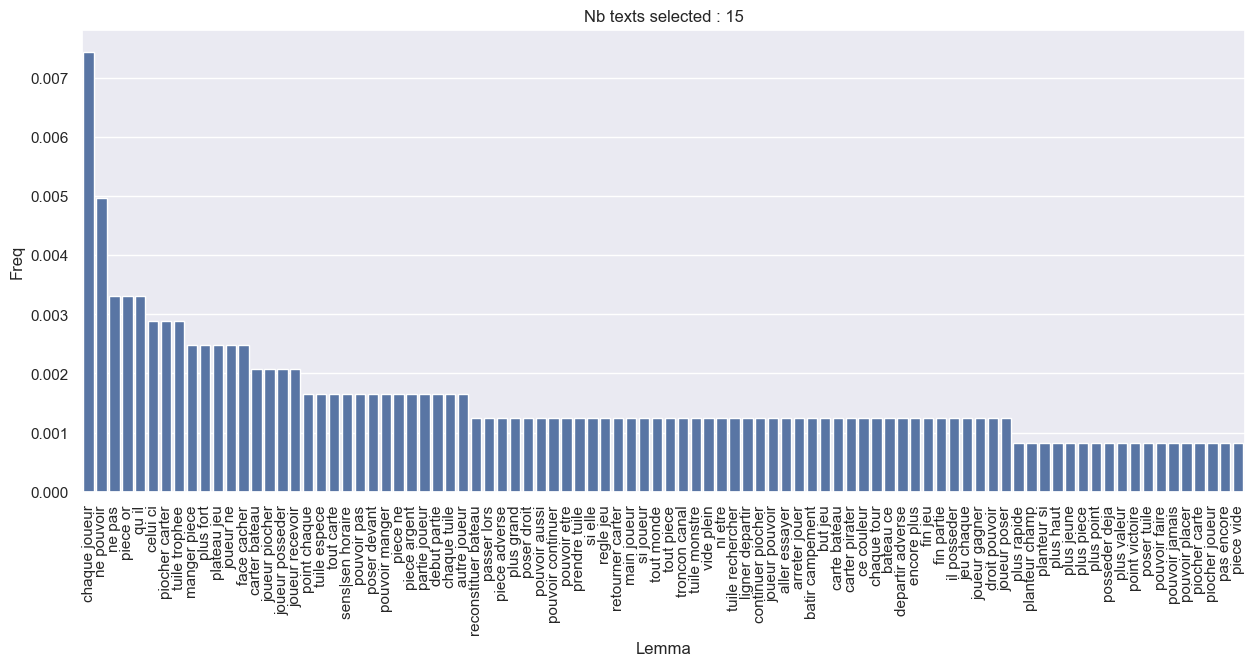

In [87]:
desc_llm = describe_cluster(26, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 27 ?

1. Les Princes d'une Province Chinoise : Un jeu de stratégie où les joueurs incarnent des princes qui doivent gérer leur province pour maximiser leurs points de victoire. Ils utilisent des personnages, des événements et des actions pour surmonter les difficultés.

2. Le Coin de la Mémoire : Un jeu de mémoire où les joueurs essaient de déplacer des pions en ligne pour atteindre l'objectif de faire gagner le cochon victorieux. Chaque joueur a un deck de cartes qui lui permettent de récolter des jetons.

3. La Course aux Billes : Un jeu de chance et de stratégie où les joueurs tentent de faire tomber des billes dans un bidon percé pour gagner le jeu.

4. Le jeu du Set : Un jeu de reconnaissance rapide où les joueurs doivent identifier des sets de 3 cartes avec des symboles identiques ou différents sur quatre caractéristiques.

5. La découverte : Un jeu de dessin et de déduction où le meneur de jeu prend une carte et décrit un dessin ou un mot en termes techniques, puis les autres joueurs dessinent ce qu'ils pensent avoir vu.

Nb texts : 92 92
Description embeddings completed
Distance descriptions :  [0.1965556  0.19878727 0.21320339 0.21879955 0.22223321 0.22643926
 0.22725643 0.22968666 0.23152569 0.23472319]
CENTER DESC : Des pions de 5 couleurs différentes que tous les joueurs déplacent et qui leur permettent de
récolter des jetons dans les mêmes couleurs. Les dits jetons vaudront plus ou moins de points à la
fin de la partie selon la place finale des pions de la même couleur sur le parcours. 

Nb words: 2453
2
Nb tokens: 3959
Voici les résumés des descriptions des jeux en français :

1. **Les Princes d'une province chinoise** : Les joueurs incarèrent des princes et doivent gérer leur province pour accumuler des points de victoire. Ils peuvent utiliser des personnages, des évènements et des cartes d'action pour surmonter les difficultés.
 * Mécaniques clés : Gestion de la province, utilisation de personnages et d'évènement pour résoudre des problèmes
 * Target audience : Joueurs stratégiques et gérant de

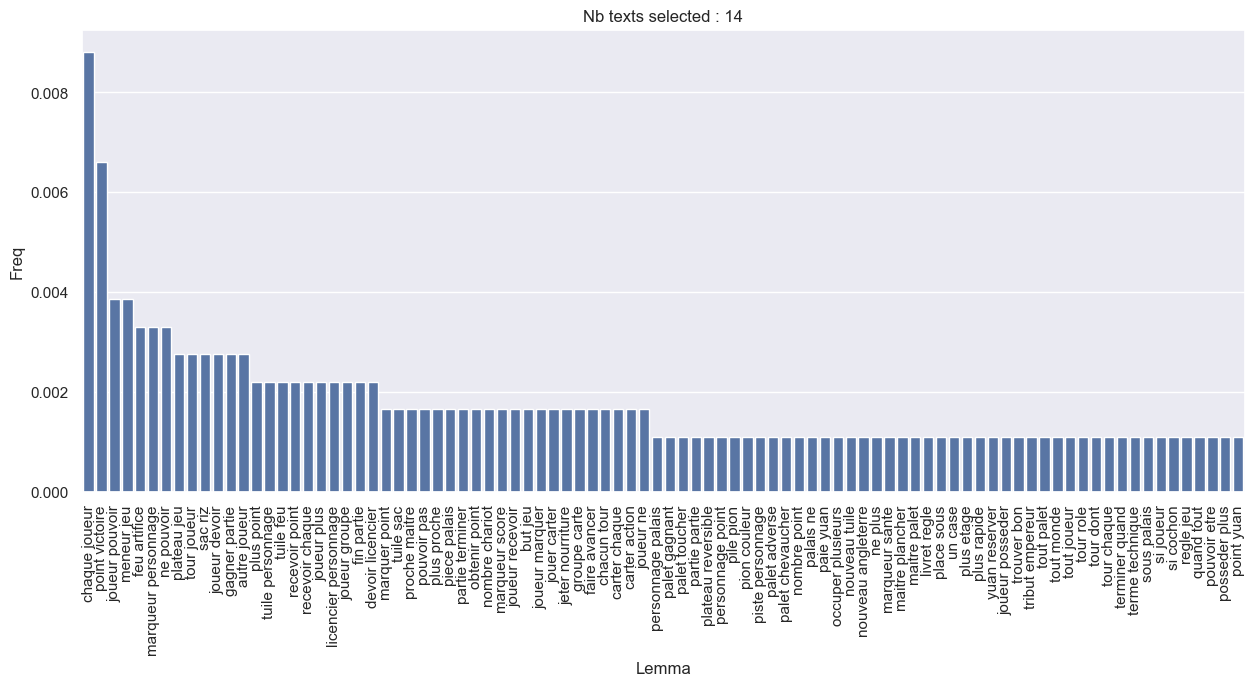

In [88]:
desc_llm = describe_cluster(27, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 28 ?

1. Le jeu consiste à mémoriser les cartes objets et à être le premier joueur à les récupérer pour gagner la partie. Il y a 7 catégories de cartes avec 49 cartes objet.
2. Un jeu où les joueurs lancent dés pour trouver des combinaisons de symboles et couleurs, puis s'emparer d'un maximum de disques reproduisant cette combinaison.
3. Le jeu est une épopée coopérative où les joueurs doivent collaborer pour reconquérir le Royaume d'Andor en utilisant des cartes pour combattre, déplacer ou profiter de capacités spéciales.
4. Un jeu où deux joueurs s'affrontent sur un plateau de 11 cases et doivent occuper un maximum de cases pour gagner.
5. Le jeu est construit au moyen âge et consiste à construire des tours pour montrer sa richesse, en utilisant des cartes de construction et des objets.
6. Un jeu où les joueurs naviguent dans différentes époques de l'histoire et doivent accumuler des ressources et des points pour gagner.
7. Le jeu est basé sur la collecte de pierres précieuses et consiste à acquérir des îles, puis à les échanger contre des pierres précieuses.
8. Un jeu où les joueurs placent des tuiles sur un plateau de manière à obtenir une zone plus large de tuiles connectées de leur couleur que celle de leur adversaire.
9. Un jeu où les joueurs doivent rétranscrire la colère des dieux en détruisant des parties de l'île et en protégeant leurs fidèles, tout en cachant le lieu de culte.

Nb texts : 84 84
Description embeddings completed
Distance descriptions :  [0.20672597 0.21112341 0.21794368 0.22280393 0.22488291 0.23245551
 0.23581558 0.23716847 0.24045704 0.24126596]
CENTER DESC : Ce jeu se déroule au moyen âge où des hommes riches inspirés vont construire des tours magnifiques
afin de montrer à quel point ils prospèrent. Comme vous vous en doutez, plus la tour est grande,
plus la famille est influente car on la pense plus riche. Les joueurs sont les constructeurs de ces
tours essayant de profiter de la vanité de ces riches familles. Il vous faudra construire au bon
endroit au bon moment et jouer vos cartes à bon escient: votre nom sera deviendra alors célèbre et
sera associé à celui du plus riche et plus puissant des marchands ! ce jeu contient 149 morceaux en
bois de tour, 55 cartes de construction, 20 marqueurs de prestige et une fiche/conseil de jeu à côté
double. Principe du jeu : Chaque joueur possède trois cartes en main et doit en jouer une pendant
son tou

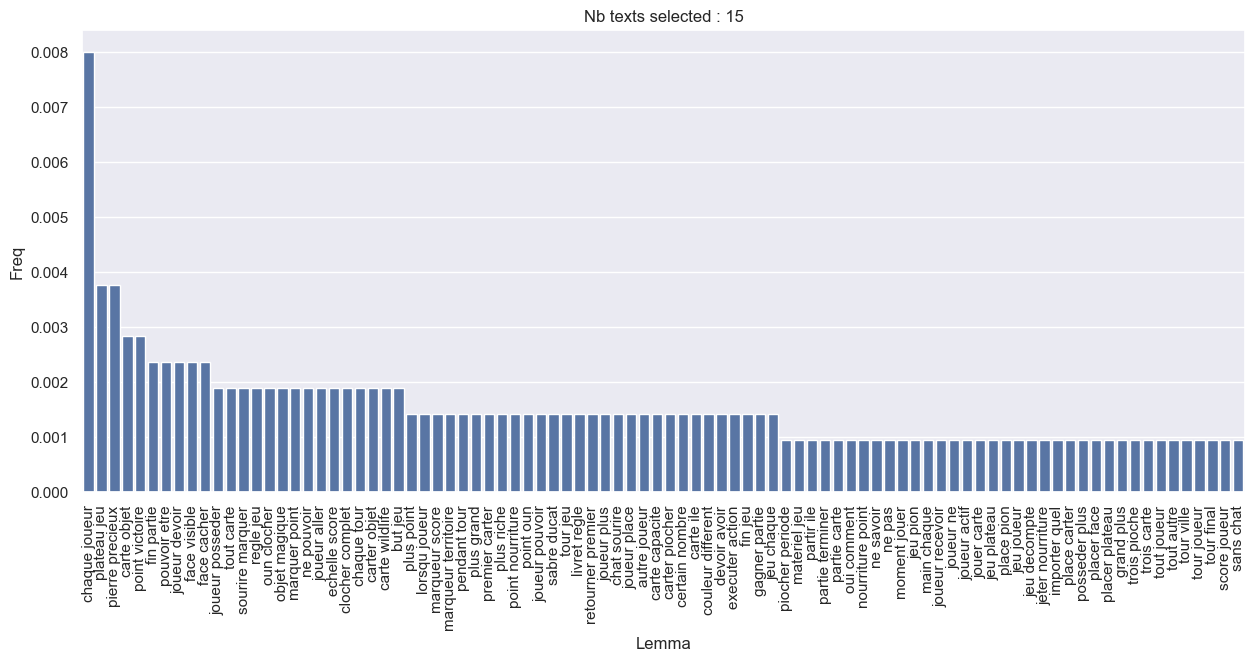

In [91]:
desc_llm = describe_cluster(28, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)
#print("Games selected", cluster_desc.shape[0])
cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Cluster 29 ?

. Le jeu "Saboteur" est un jeu de stratégie où les joueurs doivent déterminer si un joueur est un chercheur ou un saboteur. Les chercheurs cherchent à trouver de l'or, tandis que les saboteurs tentent de le freiner. Le jeu se termine lorsque 3 manches sont jouées et le joueur qui a le plus d'or gagne.

2. Le jeu "Dés de capture" est un jeu de stratégie où les joueurs doivent placer leurs dés pour capturer les autres joueurs. Les dés peuvent être placés adjacément pour créer des captures, mais si la somme des valeurs des dés est supérieure à 6, aucun capturing n'a lieu.

3. Le jeu "Jungle" est un jeu de rôle où les joueurs incarnent des explorateurs qui doivent survivre dans une jungle hostile. Les joueurs peuvent utiliser leurs compétences et leurs armes pour se battre contre les autres joueurs et rester en vie.

4. Le jeu "Train de fer" est un jeu de stratégie où les joueurs doivent aiguiller des wagons vers leur quai pour composer un train. Les joueurs peuvent utiliser des cartes pour influencer la situation et gagner des points de victoire.

5. Le jeu "Taverne de la fée clocharde" est un jeu de rôle où les joueurs incarnent des personnages avec des pouvoirs spéciaux. Les joueurs doivent agir simultanément, dépenser leurs butins et utiliser leurs pouvoirs pour gagner des points de victoire.

6. Le jeu "Escargots" est un jeu de course où les joueurs doivent avancer sur une piste de course en utilisant des cartes de vitesse et d'action. Les joueurs peuvent gagner des points en fonction de leur position à l'arrivée.

7. Le jeu "Concurrence ferroviaire" est un jeu de stratégie où les joueurs doivent aiguiller des wagons vers leur quai pour composer un train. Les joueurs peuvent utiliser des cartes pour influencer la situation et gagner des points de victoire.

8. Le jeu "Saboultin" est un jeu de rôle où les joueurs incarnent des personnages avec des pouvoirs spéciaux. Les joueurs doivent agir simultanément, dépenser leurs butins et utiliser leurs pouvoirs pour voler des bijoux et gagner des points de victoire.


Nb texts : 96 96
Description embeddings completed
Distance descriptions :  [0.20555557 0.21050699 0.22328911 0.22769355 0.22812295 0.23088389
 0.23775505 0.23830005 0.241359   0.24304384]
CENTER DESC : Les joueurs incarnent un explorateur devant se battre contre ses compagnons pour ne pas finir
capturé par les indigènes et réussir à atteindre l'avion, seul moyen de quitter la jungle. Chaque
personnage dispose de capacités liées à son arme, avec laquelle ils peuvent charger, tirer et se
protéger. Simultanément, les joueurs miment l'action choisie et font le bruitage correspondant.
Contenu : ✔ 1 Règle de jeu ✔ 6 Aides de jeu (4 langues) ✔ 1 Plateau ✔ 6 Personnages ✔ 6 Cartes
Personnage ✔ 33 pions 

Nb words: 2535
2
Nb tokens: 4010
Je vais analyser les descriptions du jeu pour vous identifier les mécaniques clés, la cible d'audience, la complexité et autres éléments importants.

**Mécaniques clés :**

1. **Bluffing** : Les jeux qui impliquent le bluffing, tels que Saboteur, sont très popu

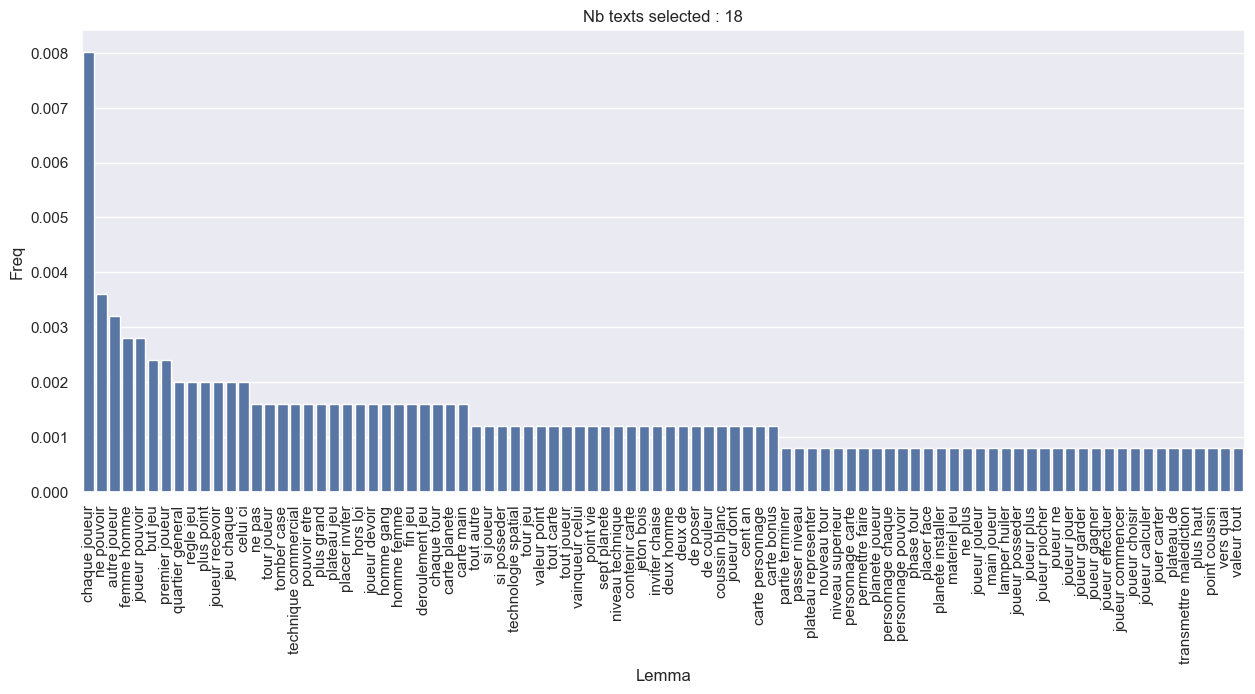

In [109]:
desc_llm = describe_cluster(29, 1.25, 1.25, 10, games_clusters, desc_lemmatized, desc_embeddings, comment_lemmatized, comment_real, comments=False)

cluster_desc = desc_llm.assign(Batch=assign_batch_number(desc_llm, 2000))
cluster_desc_batched = cluster_desc.groupby("Batch")["Description"].apply("\n".join).tolist()

print("Nb words:", calc_nb_words(cluster_desc["Description"]))
response=call_model_by_batch(cluster_desc_batched, "descriptions")
print(response["message"]["content"])

### Generate user's comment on the game (KNN based)

In [ ]:
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
cos_sim_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")

In [ ]:
user, game = 1, 6123
user_ind = users_table[users_table.values == user].item()

# Find similar users
similar_users_ind = get_KNN(cos_sim_matrix, 40, user_ind)
similar_users = users_table[users_table.index.isin(similar_users_ind)].values

# Get similar users comments 
similar_comments = rev_filter[rev_filter["User id"].isin(similar_users) & (rev_filter["Game id"] == game)]
similar_comments = similar_comments.assign(Batch=assign_batch_number(similar_comments, 2300))
similar_comments_batched = similar_comments.groupby("Batch")["Comment body"].apply("\n".join).tolist()

print("Nb words", calc_nb_words(similar_comments["Comment body"]))
# Call model
response = call_model_by_batch(similar_comments_batched, "generate_comment")
print("GENERATED comment")
print("\n".join(textwrap.fill(word, width=100) for word in response.split('\n')))


Nb words 481
1


KeyboardInterrupt: 

In [ ]:
# Real comment
real_comment = rev_filter[(rev_filter["User id"] == user) & (rev_filter["Game id"] == game)]["Comment body"].item()
print("REAL comment")
print(textwrap.fill(real_comment, width=100))

REAL comment
Il y a un truc entre moi et Maka Bana, je ne rechigne pas à y jouer mais je n'ai pas vraiment envie
de l'acheter. Je crois qu'il me fait plus rêver, de part ses couleurs, son imaginaire exotique, ses
petites paillotes, qu'il me passionne au niveau ludique.Pourtant, c'est un jeu bien foutu. Un jeu de
bluff et de déduction. Amener les adversaires sur des fausses pistes pour se placer ailleurs en est
tout le sel (marin).3 ème édition avec quelques changements : un club de plongée / le fait
d'annoncer ouvertement que l'on va jouer une carte spéciale... pour le reste, on ne change pas une
équipe qui gagne.APPELEZ MOI LE DIRECTEUR !Alors oui, on se la pète: 2 plateaux de jeu ???, alors
qu'il aurait été plus simple de faire un recto verso, mais pourquoi pas...Mais si c'est pour rogner
sur le reste, alors non. les cartes sont tout bonnement MERDIQUES, c'est juste honteux de proposer
une qualité aussi pauvre , pas plastifiées, elles sont moins épaisses que des cartes de visite, ave

In [ ]:
user, game = 201, 2921
#rev_filter[rev_filter["User id"] == user].merge(games_count, on="Game id").sort_values("count").tail(30)
user_ind = users_table[users_table.values == user].item()

# Find similar users
similar_users_ind = get_KNN(cos_sim_matrix, 40, user_ind)
similar_users = users_table[users_table.index.isin(similar_users_ind)].values

# Get similar users comments 
similar_comments = rev_filter[rev_filter["User id"].isin(similar_users) & (rev_filter["Game id"] == game)]
similar_comments = similar_comments.assign(Batch=assign_batch_number(similar_comments, 2300))
similar_comments_batched = similar_comments.groupby("Batch")["Comment body"].apply("\n".join).tolist()

print("Nb words", calc_nb_words(similar_comments["Comment body"]))
# Call model
response = call_model_by_batch(similar_comments_batched, "generate_comment")
print("GENERATED comment")
print("\n".join(textwrap.fill(word, width=100) for word in response.split('\n')))


Nb words 488
1
GENERATED comment
Voici une nouvelle commentaires qui reflète le sentiment général et les thèmes des commentaires
précédents, tout en apportant quelques variations de style et de phrasing :

"Un véritable chef-d'œuvre de la mécanique de jeu, El Grande est à la fois simple, élégante et
subtile, mais également incroyablement complexe et stratégique. Le jeu de placement et
d'opportunisme est parfaitement équilibré, avec une bonne dose de chance (mais pas trop, grâce aux
extensions) qui ajoute un élément de suspense à la partie. La notion de jouer dans les premiers ou
les derniers tourne autour du blocage des autres joueurs en jouant le roi, ce qui crée une dynamique
de jeu intense et excitante.

Le plateau de jeu est un vrai showman, avec son illustration détestable (mais nous n'allons pas y
toucher !) et son système de comptage d'actions très ludique. Les cubes en bois, bien que dérisoires
à première vue, s'avèrent être une véritable puissance stratégique, permettant aux j

In [ ]:
# Real comment
real_comment = rev_filter[(rev_filter["User id"] == user) & (rev_filter["Game id"] == game)]["Comment body"].item()
print("REAL comment")
print(textwrap.fill(real_comment, width=100))

REAL comment
Un jeu trés plaisant à partir de 4 joueurs.C'est un jeu d'alliance, les joueurs les plus faibles
pouvant se liguer contre le meneur. Les coups bas peuvent donner lieu à des vengeances assassines.
Pour ne pas s'attirer les foudres de ses adversaires, le fin diplomate s'efforcera de passer
inaperçu tout en ayant pour objectif final de distancer les autres.Un subtil mélange de hasard, de
réflexion et surtout d'opportunité fait de EL GRANDE un jeu trés attachant.A chaque tour, les
dilemnes sont cruels et quelquefois fatals: doit-on privilégier un nombre restreint de régions pour
y déposer ses "caballeros" ou doit-on au contraire s'éparpiller pour grapiller de-ci de-là quelques
points?La gestion de sa "cour" est primordiale. Le stock de "caballeros" qu'elle constitue doit être
en permanence suffisant pour permettre un placement optimal sur la carte ou dans le "castillo"
(sorte de tirelire décomptée à certains moments de la partie).Seulement voilà, les cartes qui
permettent de r

In [ ]:
user, game = 208, 3650
#rev_filter[rev_filter["User id"] == user].merge(games_count, on="Game id").sort_values("count").tail(30)
user_ind = users_table[users_table.values == user].item()

# Find similar users
similar_users_ind = get_KNN(cos_sim_matrix, 40, user_ind)
similar_users = users_table[users_table.index.isin(similar_users_ind)].values

# Get similar users comments 
similar_comments = rev_filter[rev_filter["User id"].isin(similar_users) & (rev_filter["Game id"] == game)]
similar_comments = similar_comments.assign(Batch=assign_batch_number(similar_comments, 2300))
similar_comments_batched = similar_comments.groupby("Batch")["Comment body"].apply("\n".join).tolist()

print("Nb words", calc_nb_words(similar_comments["Comment body"]))
# Call model
response_full, response = call_model_by_batch(similar_comments_batched, "generate_comment")
print("GENERATED comment")
print("\n".join(textwrap.fill(word, width=100) for word in response.split('\n')))


Nb words 3429
2
GENERATED comment
Voici une nouvelle commentaire qui reflète les thèmes généraux et les opinions exprimées par les
utilisateurs :

"J'ai eu le plaisir de découvrir Gosu, un jeu de cartes qui m'a vraiment captivé. Les règles sont
simples et rapidement expliquées, mais il est clair que cela cède place à une profondeur et une
complexité qui récompense les joueurs expérimentés. La variété des cartes et des pouvoirs associés
est impressionnante, et je me suis déjà trouvé à déborder de joie lorsqu'un combo m'a réussi.

Cependant, je dois admettre que j'ai rencontré quelques difficultés pour comprendre les interactions
entre les cartes et les règles. La lecture des cartes peut parfois être un peu lente, ce qui peut
ralentir le jeu. De plus, la pioche peut être un élément de hasard qui peut déstabiliser les plans
des joueurs.

Mais ce n'est pas le seul point où je me suis senti frustré. Par moments, je me suis senti un peu
bloqué et incapable de prendre des décisions stratégiqu

In [ ]:
response_full

ChatResponse(model='llama3.2', created_at='2025-04-07T14:24:32.423276Z', done=True, done_reason='stop', total_duration=75915259292, load_duration=836115042, prompt_eval_count=5453, prompt_eval_duration=30192436167, eval_count=546, eval_duration=44875834708, message=Message(role='assistant', content='Voici une nouvelle commentaire qui reflète les thèmes généraux et les opinions exprimées par les utilisateurs :\n\n"J\'ai eu le plaisir de découvrir Gosu, un jeu de cartes qui m\'a vraiment captivé. Les règles sont simples et rapidement expliquées, mais il est clair que cela cède place à une profondeur et une complexité qui récompense les joueurs expérimentés. La variété des cartes et des pouvoirs associés est impressionnante, et je me suis déjà trouvé à déborder de joie lorsqu\'un combo m\'a réussi.\n\nCependant, je dois admettre que j\'ai rencontré quelques difficultés pour comprendre les interactions entre les cartes et les règles. La lecture des cartes peut parfois être un peu lente, ce

In [ ]:
# Real comment
real_comment = rev_filter[(rev_filter["User id"] == user) & (rev_filter["Game id"] == game)]["Comment body"].item()
print("REAL comment")
print(textwrap.fill(real_comment, width=100))

REAL comment
Les + :Règles simples et vite expliquéesS’emporte partout (si l’on ne conserve que les cartes et les
points de victoire)Quelle variété dans les cartesInteractionLes - :Taille de la boîte un peu
importante pour ce quelle contient (mais ce type de jeu permet très facilement de faire des
extensions, la place dans la boîte est sans doute déjà prévue)Thème (j’adhère moyen)Il faut faire au
moins une partie pour se familiariser les cartes et les combos possiblesPasser et regarder l’autre
(ou les autres) jouer pendant plusieurs toursPart de hasard trop importante. Le victoire est souvent
au bout de la pioche ! Donc :Gosu est un jeu correct à 2 mais le fait de gagner parce que l’on a
pioché telle ou telle carte n’est pas très valorisant. J’apprécie plus les jeux où l’on gagne parce
que l’on a bien joué et non bien pioché
